In [1]:
# 导入必要的库
import os
import json
import traceback
from pathlib import Path
import pandas as pd
import torch
from tqdm import tqdm
from filelock import FileLock
import matplotlib.pyplot as plt
from hamer.configs import dataset_eval_config, CACHE_DIR_HAMER
from hamer.datasets import create_dataset
from hamer.utils import Evaluator, recursive_to
from hamer.models import download_models, load_hamer, DEFAULT_CHECKPOINT

# 参数设置
checkpoint_path = DEFAULT_CHECKPOINT  # 预训练模型路径
results_folder = "results"  # 保存测试结果的文件夹
# dataset_name = "FREIHAND-VAL"  # 数据集名称
dataset_name = "NEWDAYS-TEST-ALL"
batch_size = 16  # 批量大小
num_workers = 4  # DataLoader 的线程数
log_freq = 10  # 日志频率
shuffle = False  # 是否对数据集进行打乱

# 创建保存结果的目录
os.makedirs(results_folder, exist_ok=True)

# 下载和加载模型
download_models(CACHE_DIR_HAMER)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, model_cfg = load_hamer(checkpoint_path)
model = model.to(device).eval()

# 加载数据集配置
dataset_cfg = dataset_eval_config()[dataset_name]
print("Dataset Configuration:", dataset_cfg)


/home/cxx/miniconda/envs/hamer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/cxx/miniconda/envs/hamer/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Dataset Configuration: DATASET_FILE: /home/cxx/Code/hamer/hamer_evaluation_data/hamer_evaluation_data/TEST_newdays_img_all.npz
IMG_DIR: /home/cxx/Code/hint/HInt_annotation_partial/TEST_newdays_img/
KEYPOINT_LIST: [0]
TYPE: ImageDataset


In [2]:
def run_eval_and_collect_results(model, model_cfg, dataset_cfg, device, batch_size, num_workers, log_freq=10):
    """
    执行模型评估，并收集 Loss 和指标结果。
    """
    # 创建数据集和 DataLoader
    dataset = create_dataset(model_cfg, dataset_cfg, train=False)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    # 初始化 Evaluator
    evaluator = Evaluator(
        dataset_length=len(dataset),
        dataset=dataset_cfg["TYPE"],
        keypoint_list=dataset_cfg["KEYPOINT_LIST"],
        pelvis_ind=model_cfg["EXTRA"]["PELVIS_IND"],
        # metrics=['mode_mpjpe', 'mode_re', 'min_mpjpe', 'min_re', 'mode_kpl2'],  # 添加更多需要的指标
        metrics = ['mode_kpl2'],
        # pck_thresholds=[0.05, 0.1, 0.15, 0.2, 0.3],
        pck_thresholds = [0.05, 0.1,0.2],
    )

    loss_dict_list = []

    # for i, batch in enumerate(tqdm(dataloader, desc="Evaluating")):
    for i, batch in enumerate(dataloader):
        batch = recursive_to(batch, device)
        with torch.no_grad():
            output = model(batch)
        loss_dict = evaluator(output, batch)
        # print(f"loss_dict: {loss_dict}")
        loss_dict_list.append(loss_dict)

        # 每隔 log_freq 打印日志
        if i % log_freq == 0:
            evaluator.log()

    # 汇总结果
    avg_loss_dict = {}
    for key in loss_dict_list[0].keys():  # 遍历每个指标
        avg_loss_dict[key] = sum(d[key].mean() for d in loss_dict_list) / len(loss_dict_list)

    metrics_summary = evaluator.get_metrics_dict()

    return avg_loss_dict, metrics_summary


In [3]:
def save_and_visualize_results(avg_loss_dict, metrics_summary, output_folder):
    """
    保存和可视化评估结果，仅显示平均值和关键指标。
    """
    # 过滤出平均值的指标（以 `kpAvg` 开头）
    filtered_metrics_summary = {k: v for k, v in metrics_summary.items() if k.startswith("kpAvg")}
    
    # 添加其他关键指标（如 `mode_kpl2`）
    if "mode_kpl2" in metrics_summary:
        filtered_metrics_summary["mode_kpl2"] = metrics_summary["mode_kpl2"]

    # 打印结果
    print("Filtered Metrics Summary (Averages):")
    for metric, value in filtered_metrics_summary.items():
        print(f"{metric}: {value:.4f}")

    # 保存到 CSV 文件
    output_csv = os.path.join(output_folder, "evaluation_results_filtered.csv")
    results_df = pd.DataFrame(
        {
            "Metric": list(filtered_metrics_summary.keys()),
            "Value": list(filtered_metrics_summary.values()),
        }
    )
    results_df.to_csv(output_csv, index=False)
    print(f"Saved filtered results to {output_csv}")

    # 可视化结果
    plt.figure(figsize=(12, 6))
    plt.bar(results_df["Metric"], results_df["Value"], color='skyblue')
    plt.title("Filtered Evaluation Results (Averages and Key Metrics)")
    plt.ylabel("Value")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


## Various parameters before optimization

/home/cxx/Code/hamer/hamer/utils/geometry.py:61: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  b3 = torch.cross(b1, b2)


100 / 1753 samples
100 samples
kp0_pck_0.05: 0.3493975903614458
kp1_pck_0.05: 0.42696629213483145
kp2_pck_0.05: 0.44680851063829785
kp3_pck_0.05: 0.4375
kp4_pck_0.05: 0.5408163265306123
kp5_pck_0.05: 0.425531914893617
kp6_pck_0.05: 0.5957446808510638
kp7_pck_0.05: 0.59375
kp8_pck_0.05: 0.6041666666666666
kp9_pck_0.05: 0.45263157894736844
kp10_pck_0.05: 0.5670103092783505
kp11_pck_0.05: 0.5360824742268041
kp12_pck_0.05: 0.5638297872340425
kp13_pck_0.05: 0.44680851063829785
kp14_pck_0.05: 0.47368421052631576
kp15_pck_0.05: 0.5578947368421052
kp16_pck_0.05: 0.46875
kp17_pck_0.05: 0.42857142857142855
kp18_pck_0.05: 0.43617021276595747
kp19_pck_0.05: 0.41935483870967744
kp20_pck_0.05: 0.43478260869565216
kpAvg_pck_0.05: 0.48601203231012075
kp0_pck_0.1: 0.7710843373493976
kp1_pck_0.1: 0.7752808988764045
kp2_pck_0.1: 0.851063829787234
kp3_pck_0.1: 0.8125
kp4_pck_0.1: 0.7755102040816326
kp5_pck_0.1: 0.8297872340425532
kp6_pck_0.1: 0.851063829787234
kp7_pck_0.1: 0.8333333333333334
kp8_pck_0.1: 

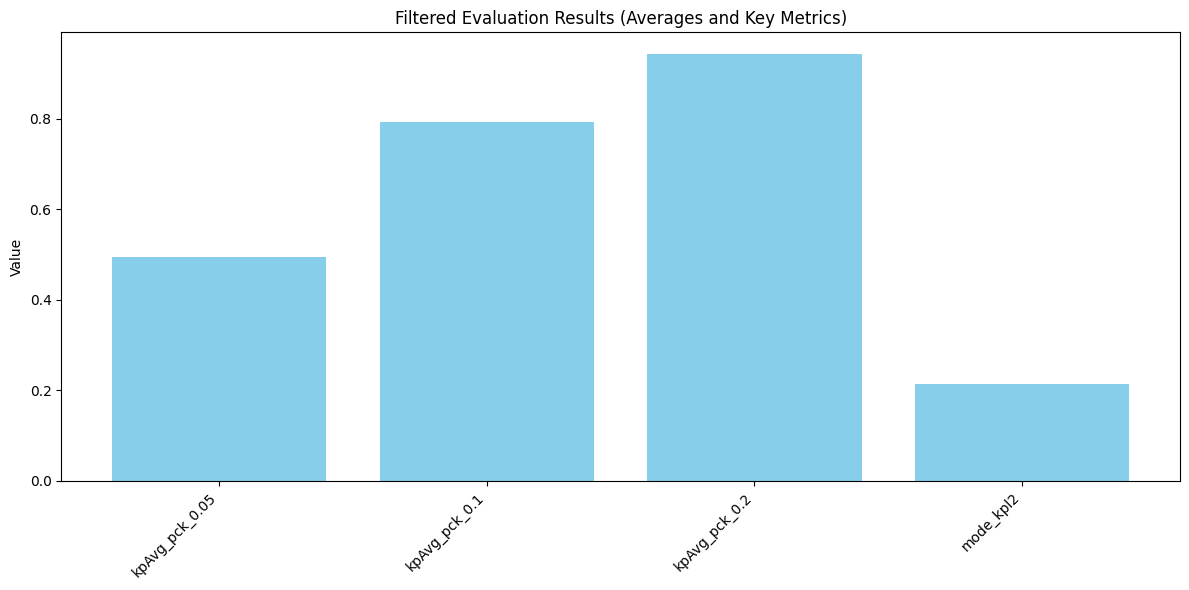

In [6]:
# 执行评估并获取结果
avg_loss_dict, metrics_summary = run_eval_and_collect_results(
    model=model,
    model_cfg=model_cfg,
    dataset_cfg=dataset_cfg,
    device=device,
    batch_size=100,
    num_workers=4,
    log_freq=10
)

# 保存并可视化结果
save_and_visualize_results(avg_loss_dict, metrics_summary, output_folder="results")



### Model Size


In [7]:
model_size = sum(p.numel() * p.element_size() for p in model.parameters())
print("Model Size (bytes):", model_size)
print("Model Size (MB)", model_size / 1024 /1024)

Model Size (bytes): 2687820192
Model Size (MB) 2563.3050842285156


### VRAM

In [9]:
# Set a input value batch
batch = {}
batch['img'] = torch.randn(1,3,256,256).to('cuda') 
batch['personid'] = torch.tensor([0]).to('cuda')
batch['box_center'] = torch.tensor([[150, 150]], dtype=torch.float64).to('cuda')
batch['box_size'] = torch.tensor([[60, 60]], dtype=torch.float64).to('cuda')
batch['img_size'] = torch.tensor([[256, 256]], device='cuda', dtype=torch.float64)
batch['right'] = torch.tensor([1. ,], device='cuda')  

# 메모리 통계 초기화
torch.cuda.reset_peak_memory_stats()
peak_memory_before = torch.cuda.max_memory_allocated()

with torch.no_grad():
    model(batch)
# 피크 메모리 사용량 측정
peak_memory_usage = torch.cuda.max_memory_allocated()
print("VRAM before (bytes):", peak_memory_before)
print("VRAM usage (bytes):", peak_memory_usage)
print("-"*40)
print("VRAM allocated (MB)", (peak_memory_usage - peak_memory_before) / 1024 / 1024)


VRAM before (bytes): 2771057664
VRAM usage (bytes): 2782329856
----------------------------------------
VRAM allocated (MB) 10.75


In [10]:
def calculate_model_size(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    total_size = param_size + buffer_size
    return total_size / (1024 ** 2)  # 转换为 MB

model_size = calculate_model_size(model)
print(f"Model size (static): {model_size:.2f} MB")

Model size (static): 2564.74 MB


### Latency

In [13]:

import time

torch.cuda.synchronize()  # 이전 연산이 완료될 때까지 대기
start_time = time.time()
with torch.no_grad():
    model(batch)
torch.cuda.synchronize()  # 모델 추론이 완료될 때까지 대기
end_time = time.time()
latency = end_time - start_time
print("Latency (seconds):", latency)

Latency (seconds): 0.052718400955200195


### MACs

In [14]:

from torchprofile import profile_macs
# 더미 입력을 사용하여 MACs 측정
num_macs = profile_macs(model, batch)
print("#MACs:", num_macs)

#MACs: 125571697354


/home/cxx/miniconda/envs/hamer/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::reshape". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/cxx/miniconda/envs/hamer/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::permute". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/cxx/miniconda/envs/hamer/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::gelu". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/cxx/miniconda/envs/hamer/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::expand". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/cxx/miniconda/envs/hamer/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::linalg_vector_norm". Skipped.
  warnings.warn('No han

### FLOPs

In [15]:

from fvcore.nn import FlopCountAnalysis

flops = FlopCountAnalysis(model, batch)
print("FLOPs:", flops.total())


Unsupported operator aten::add encountered 93 time(s)
Unsupported operator aten::mul encountered 87 time(s)
Unsupported operator aten::softmax encountered 44 time(s)
Unsupported operator aten::gelu encountered 38 time(s)
Unsupported operator aten::mul_ encountered 13 time(s)
Unsupported operator aten::add_ encountered 1 time(s)
Unsupported operator aten::linalg_vector_norm encountered 2 time(s)
Unsupported operator aten::clamp_min encountered 2 time(s)
Unsupported operator aten::expand_as encountered 2 time(s)
Unsupported operator aten::div encountered 5 time(s)
Unsupported operator aten::sub encountered 3 time(s)
Unsupported operator aten::cross encountered 1 time(s)
Unsupported operator aten::clone encountered 4 time(s)
Unsupported operator aten::eye encountered 2 time(s)
Unsupported operator aten::sub_ encountered 1 time(s)
Unsupported operator aten::pad encountered 4 time(s)
Unsupported operator aten::index_select encountered 1 time(s)
Unsupported operator aten::fill_ encountered 1

FLOPs: 125627856105.0


## Optimization

### Weight distribution
* backbone has 32 Block
* Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): DropPath(p=0.5145161151885986)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )

In [16]:
# print(model)

In [17]:
import math
def plot_backbone_block_weights(model, block_name="blocks.0", bins=256, count_nonzero_only=False, max_plots=4):
    """
    按指定的块名显示 `backbone` 的权重分布，仅显示前 max_plots 个 dim > 1 的参数。
    
    :param model: 模型对象
    :param block_name: 指定的块名，例如 "blocks.0"
    :param bins: 直方图的分箱数量
    :param count_nonzero_only: 是否仅显示非零值
    :param max_plots: 每个块最多显示的参数数量
    """
    # 获取指定块的参数，仅保留 dim > 1 的参数
    block_params = [(name, param) for name, param in model.named_parameters() 
                    if "backbone" in name and block_name in name and param.dim() > 1]
    
    # 限制最多显示 max_plots 个参数
    block_params = block_params[:max_plots]

    # 检查是否有可用参数
    if not block_params:
        print(f"No dim > 1 parameters found for block: {block_name}")
        return

    num_params = len(block_params)
    fig, axes = plt.subplots(1, num_params, figsize=(15, 3))
    if num_params == 1:
        axes = [axes]  # 确保 axes 是列表

    for idx, (name, param) in enumerate(block_params):
        print(f"name: {name}, param: {param.shape}")
        ax = axes[idx]
        if count_nonzero_only:
            param_cpu = param.detach().view(-1).cpu()
            param_cpu = param_cpu[param_cpu != 0].view(-1)
            ax.hist(param_cpu, bins=bins, density=True, color='blue', alpha=0.5)
        else:
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, color='blue', alpha=0.5)
        ax.set_xlabel(name, fontsize=8)
        ax.set_ylabel('density', fontsize=8)
        ax.tick_params(axis='x', labelsize=6)
        ax.tick_params(axis='y', labelsize=6)

    # 删除多余的子图（如果有）
    for idx in range(num_params, len(axes)):
        fig.delaxes(axes[idx])

    fig.suptitle(f'Histogram of Weights for {block_name}')
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.show()


### Original weight distribution

name: backbone.blocks.0.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.0.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.0.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.0.mlp.fc2.weight, param: torch.Size([1280, 5120])


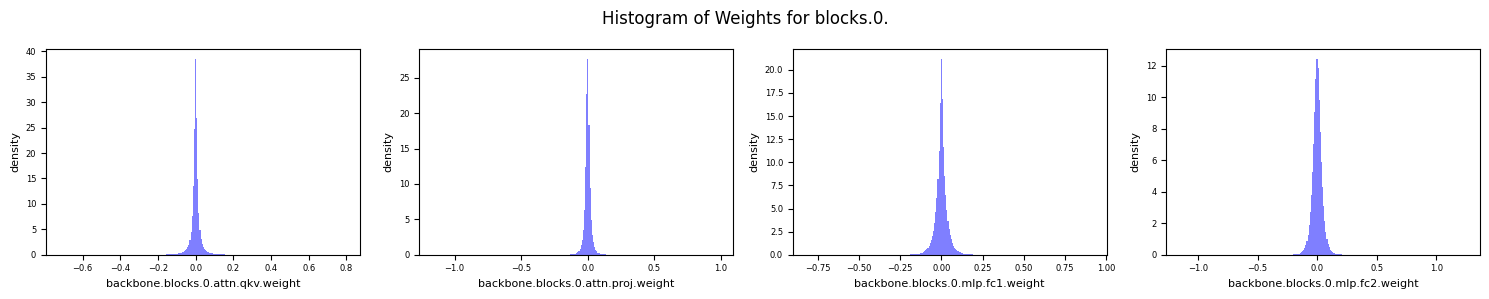

name: backbone.blocks.1.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.1.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.1.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.1.mlp.fc2.weight, param: torch.Size([1280, 5120])


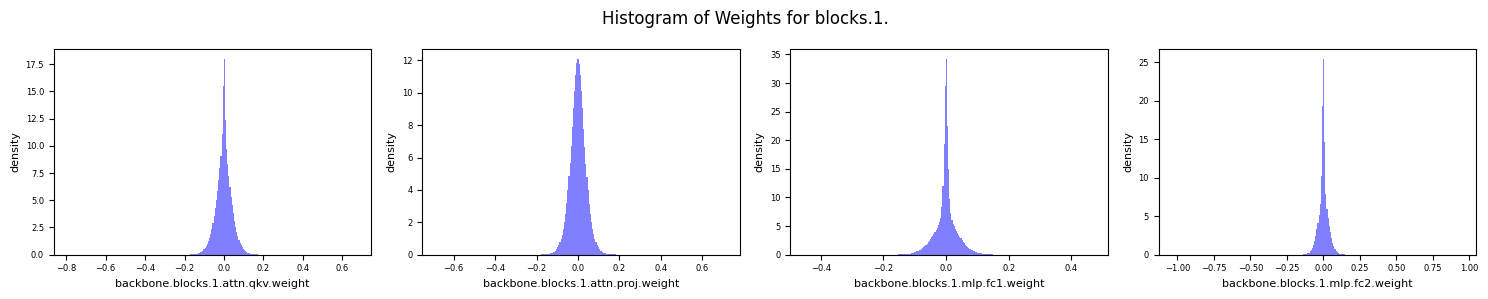

name: backbone.blocks.2.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.2.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.2.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.2.mlp.fc2.weight, param: torch.Size([1280, 5120])


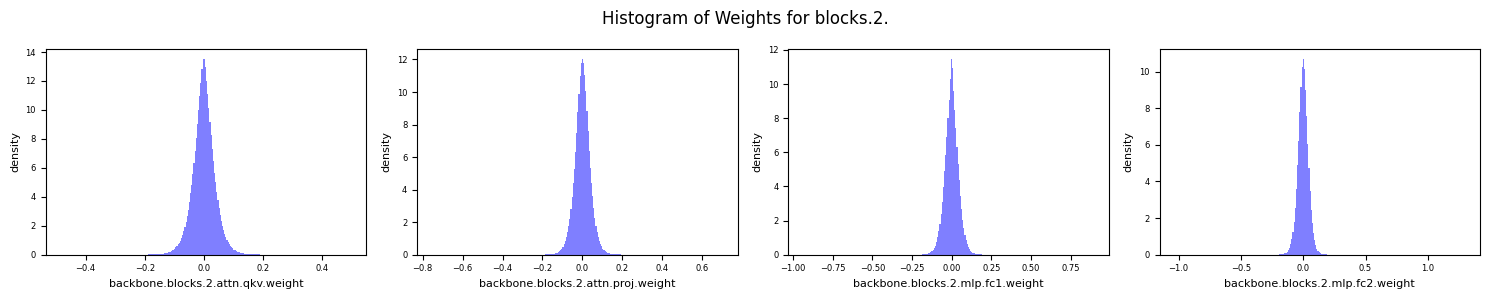

name: backbone.blocks.3.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.3.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.3.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.3.mlp.fc2.weight, param: torch.Size([1280, 5120])


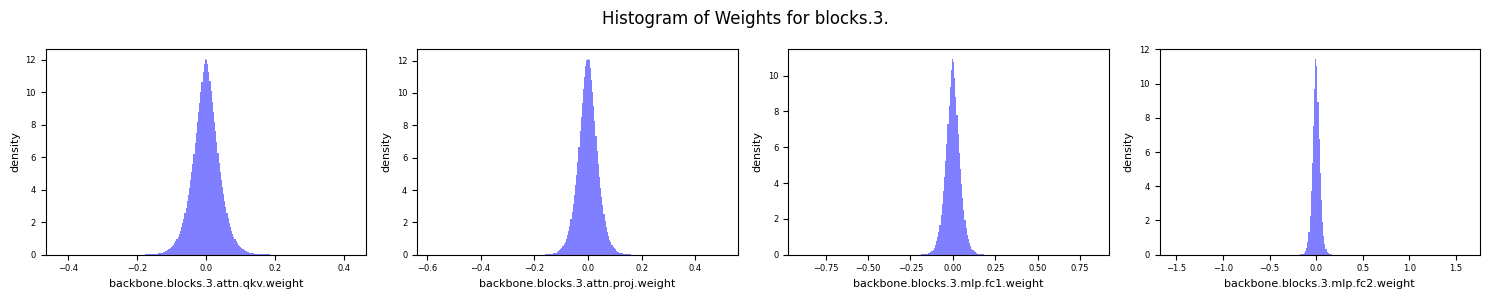

name: backbone.blocks.4.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.4.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.4.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.4.mlp.fc2.weight, param: torch.Size([1280, 5120])


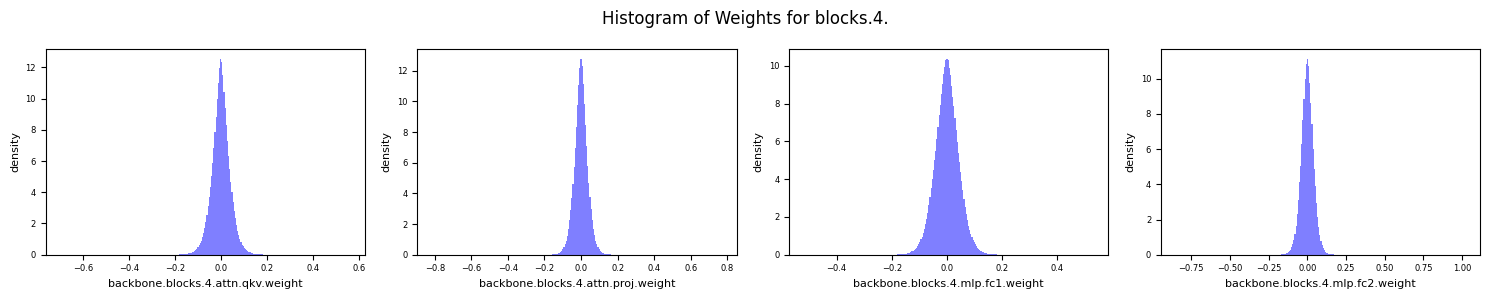

name: backbone.blocks.5.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.5.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.5.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.5.mlp.fc2.weight, param: torch.Size([1280, 5120])


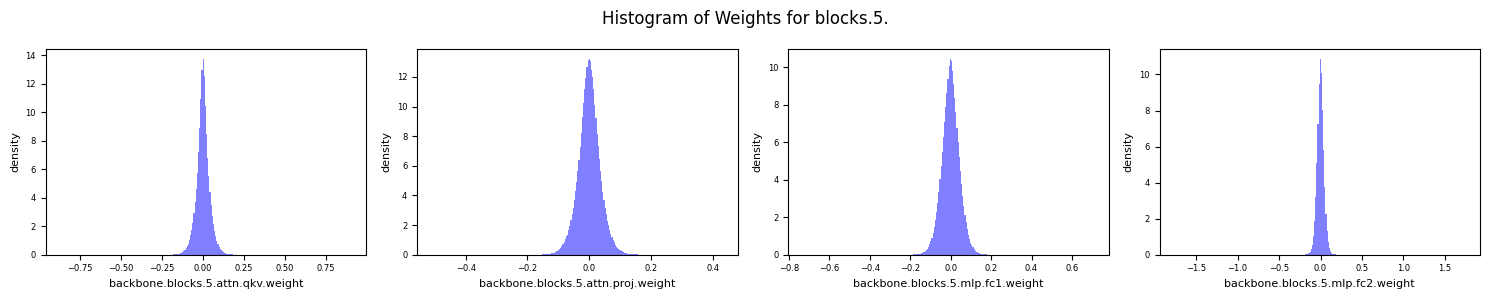

name: backbone.blocks.6.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.6.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.6.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.6.mlp.fc2.weight, param: torch.Size([1280, 5120])


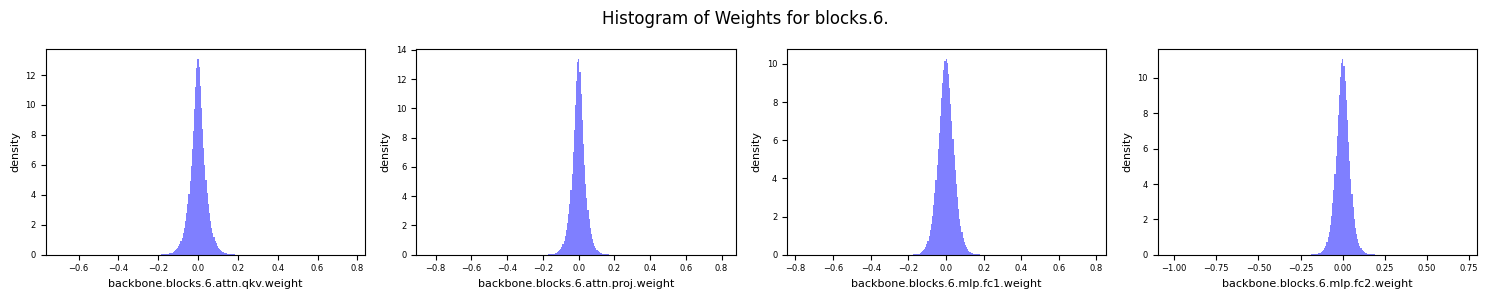

name: backbone.blocks.7.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.7.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.7.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.7.mlp.fc2.weight, param: torch.Size([1280, 5120])


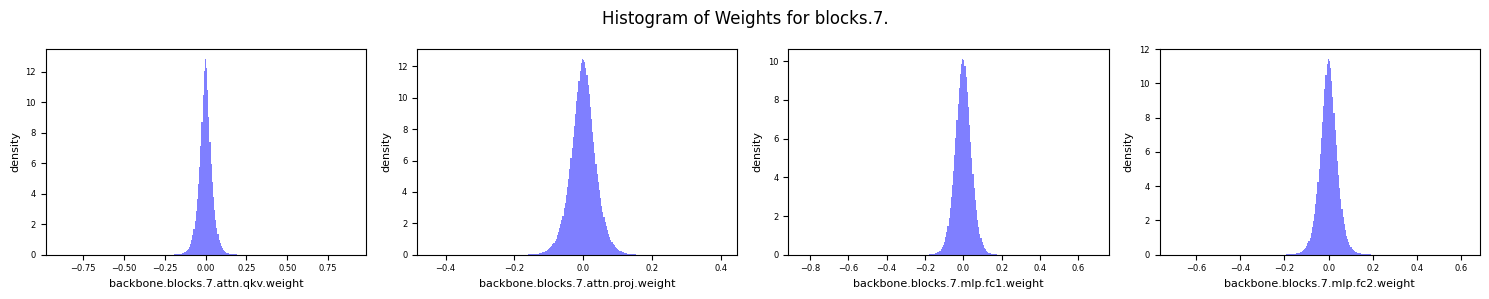

name: backbone.blocks.8.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.8.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.8.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.8.mlp.fc2.weight, param: torch.Size([1280, 5120])


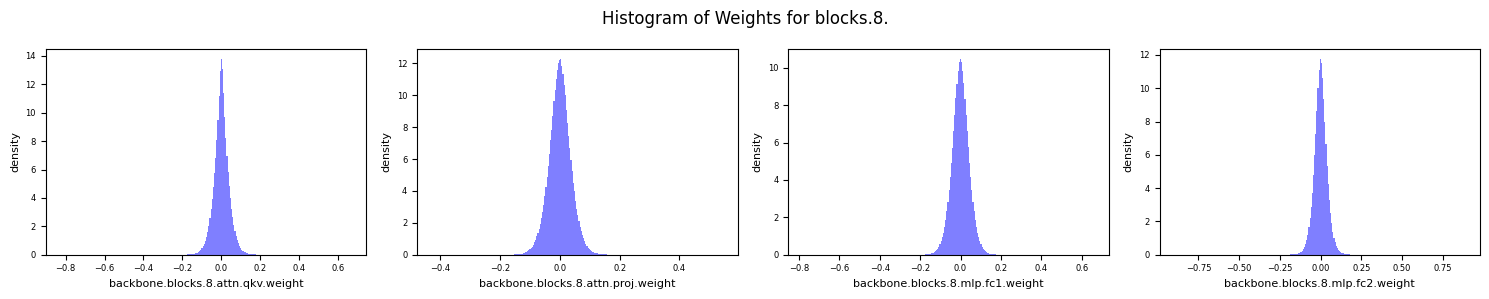

name: backbone.blocks.9.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.9.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.9.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.9.mlp.fc2.weight, param: torch.Size([1280, 5120])


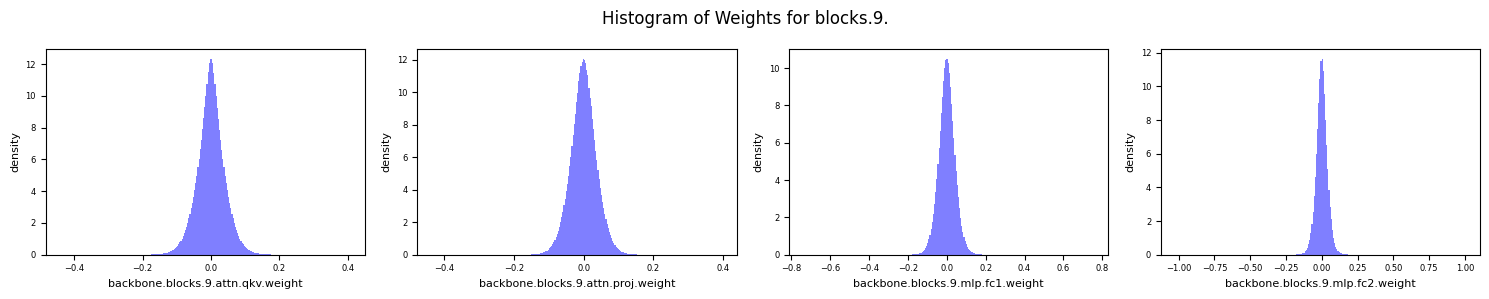

name: backbone.blocks.10.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.10.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.10.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.10.mlp.fc2.weight, param: torch.Size([1280, 5120])


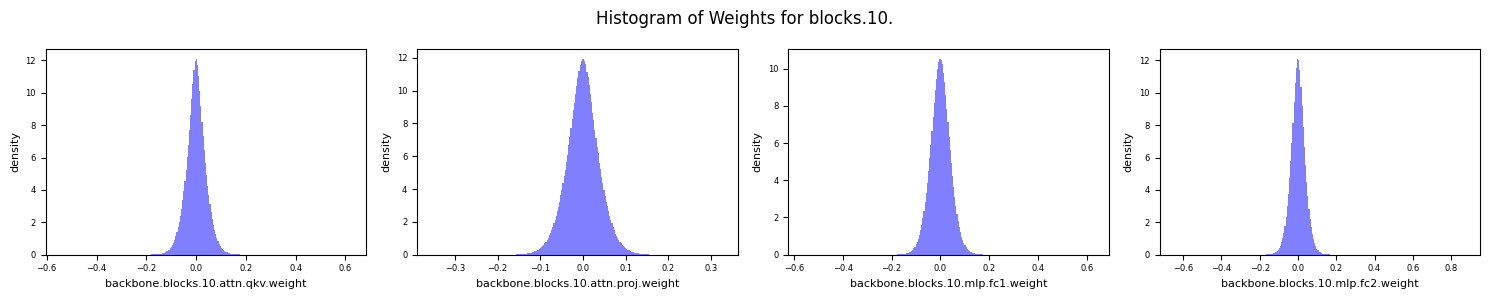

name: backbone.blocks.11.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.11.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.11.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.11.mlp.fc2.weight, param: torch.Size([1280, 5120])


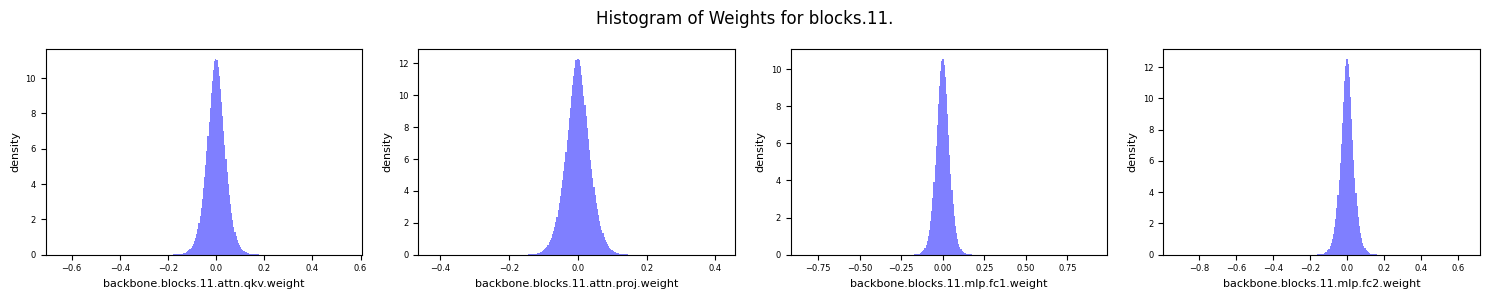

name: backbone.blocks.12.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.12.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.12.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.12.mlp.fc2.weight, param: torch.Size([1280, 5120])


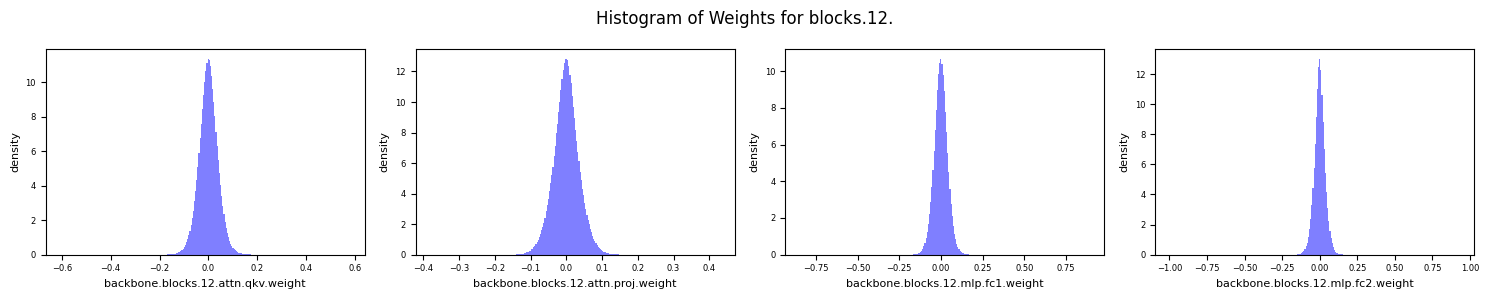

name: backbone.blocks.13.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.13.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.13.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.13.mlp.fc2.weight, param: torch.Size([1280, 5120])


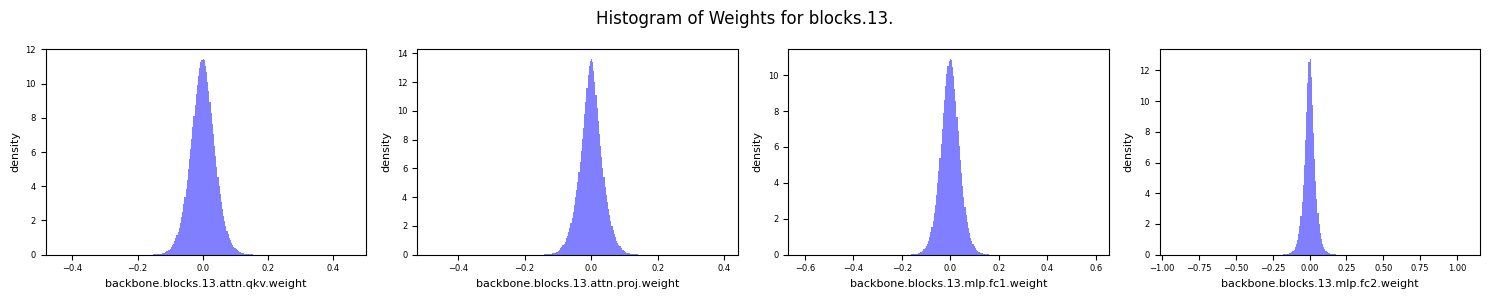

name: backbone.blocks.14.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.14.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.14.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.14.mlp.fc2.weight, param: torch.Size([1280, 5120])


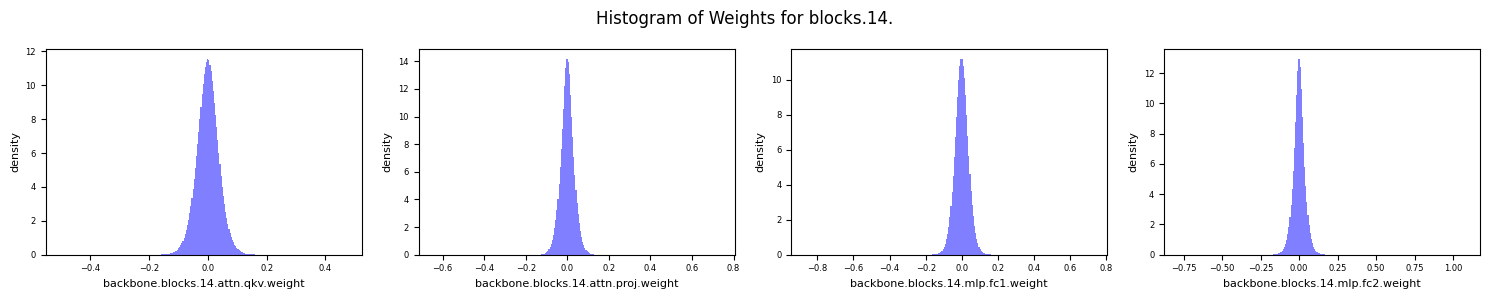

name: backbone.blocks.15.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.15.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.15.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.15.mlp.fc2.weight, param: torch.Size([1280, 5120])


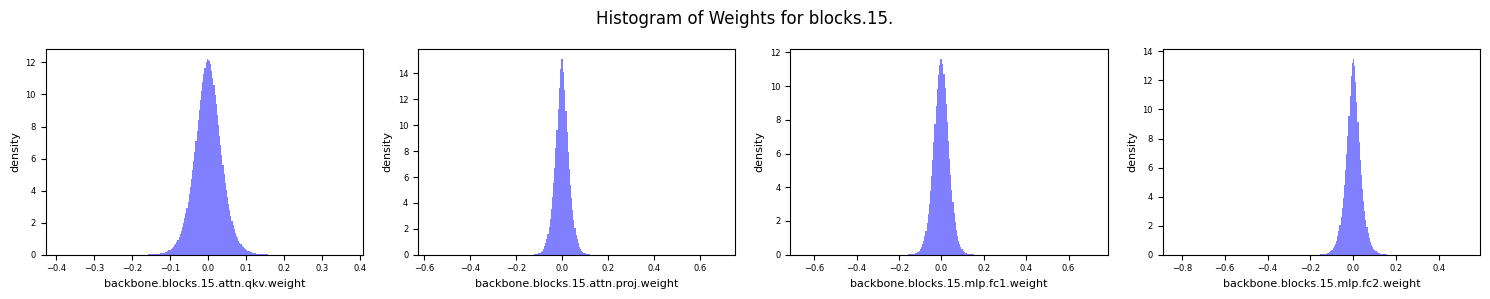

name: backbone.blocks.16.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.16.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.16.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.16.mlp.fc2.weight, param: torch.Size([1280, 5120])


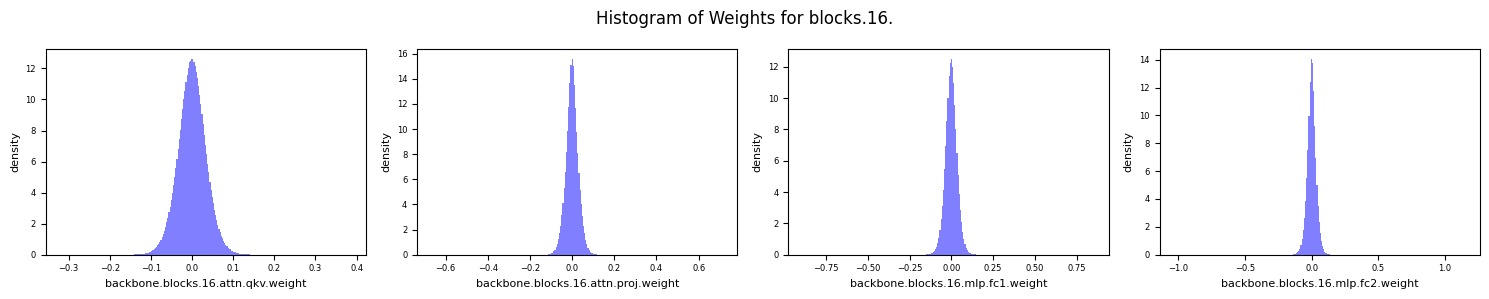

name: backbone.blocks.17.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.17.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.17.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.17.mlp.fc2.weight, param: torch.Size([1280, 5120])


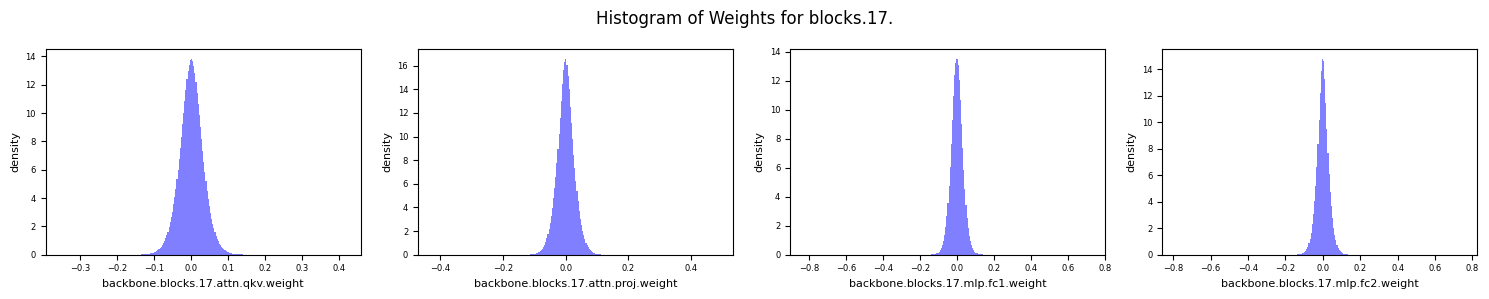

name: backbone.blocks.18.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.18.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.18.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.18.mlp.fc2.weight, param: torch.Size([1280, 5120])


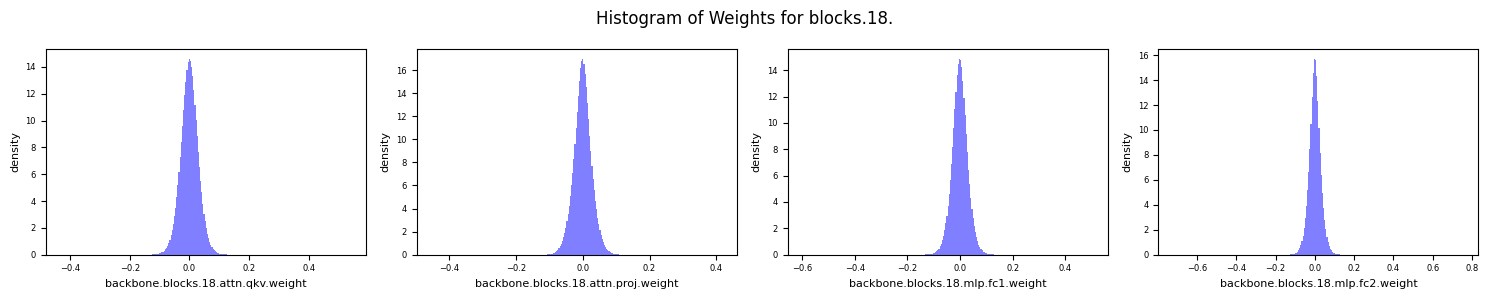

name: backbone.blocks.19.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.19.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.19.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.19.mlp.fc2.weight, param: torch.Size([1280, 5120])


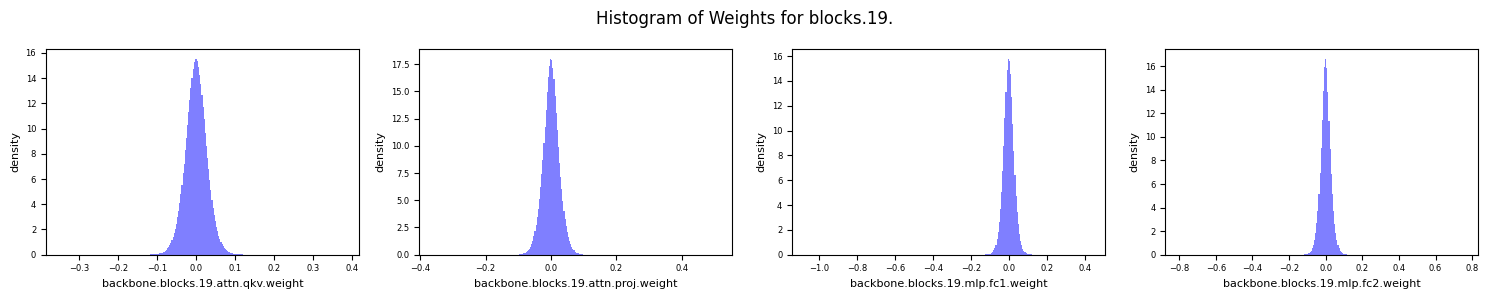

name: backbone.blocks.20.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.20.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.20.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.20.mlp.fc2.weight, param: torch.Size([1280, 5120])


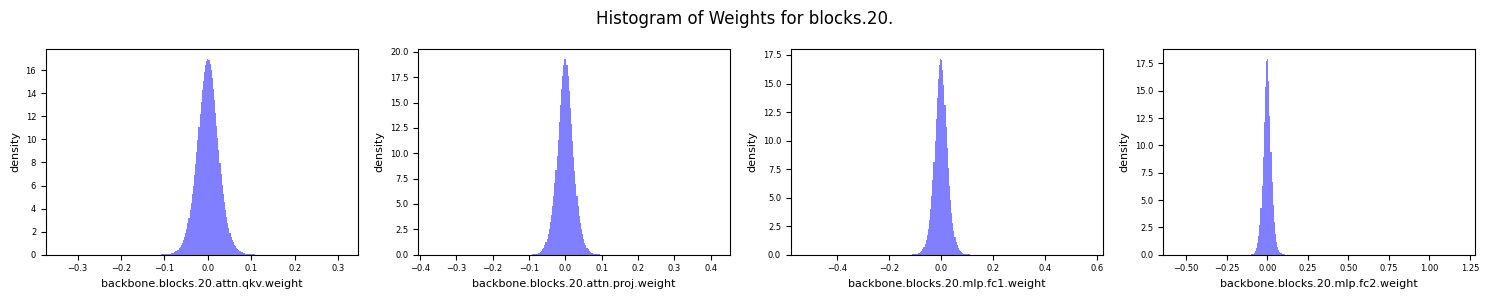

name: backbone.blocks.21.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.21.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.21.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.21.mlp.fc2.weight, param: torch.Size([1280, 5120])


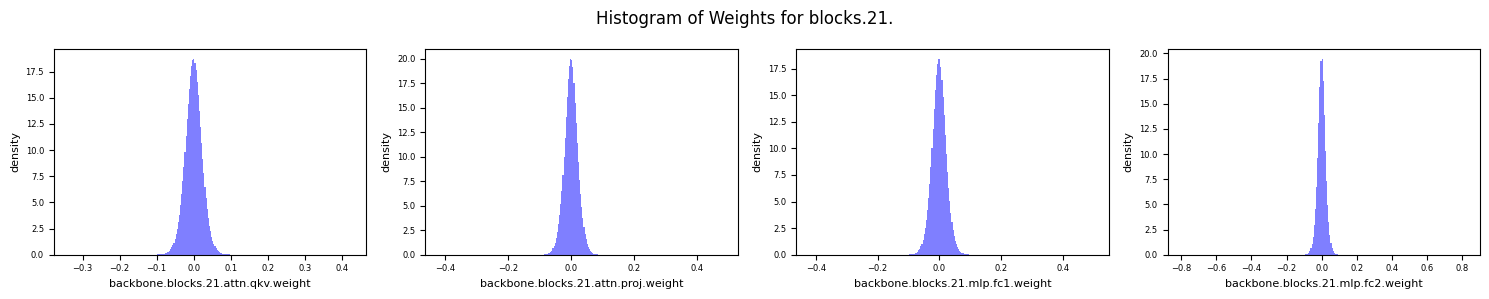

name: backbone.blocks.22.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.22.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.22.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.22.mlp.fc2.weight, param: torch.Size([1280, 5120])


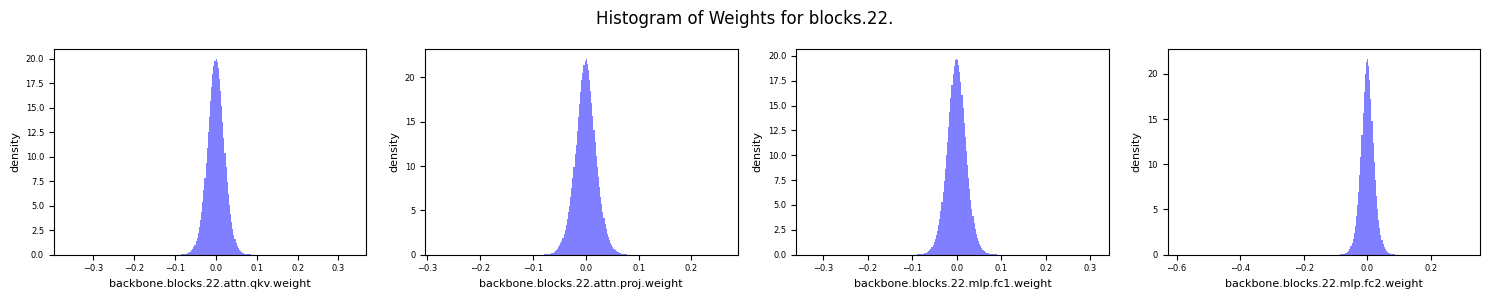

name: backbone.blocks.23.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.23.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.23.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.23.mlp.fc2.weight, param: torch.Size([1280, 5120])


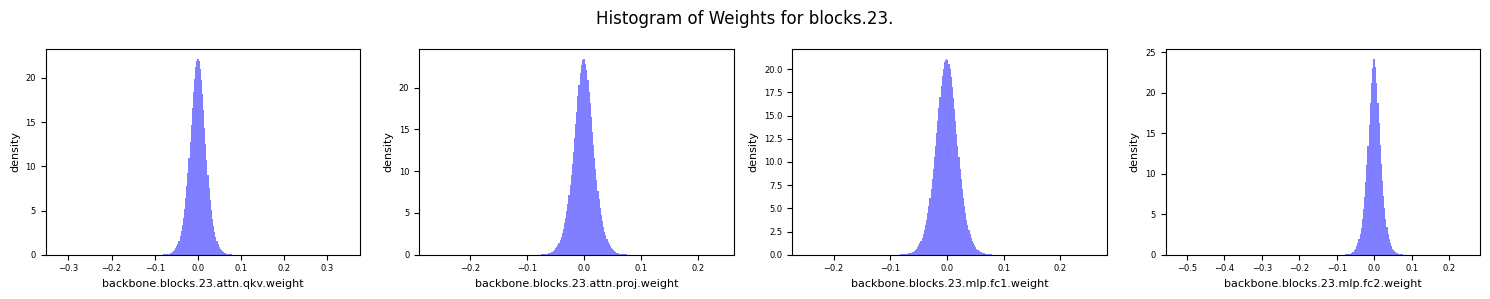

name: backbone.blocks.24.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.24.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.24.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.24.mlp.fc2.weight, param: torch.Size([1280, 5120])


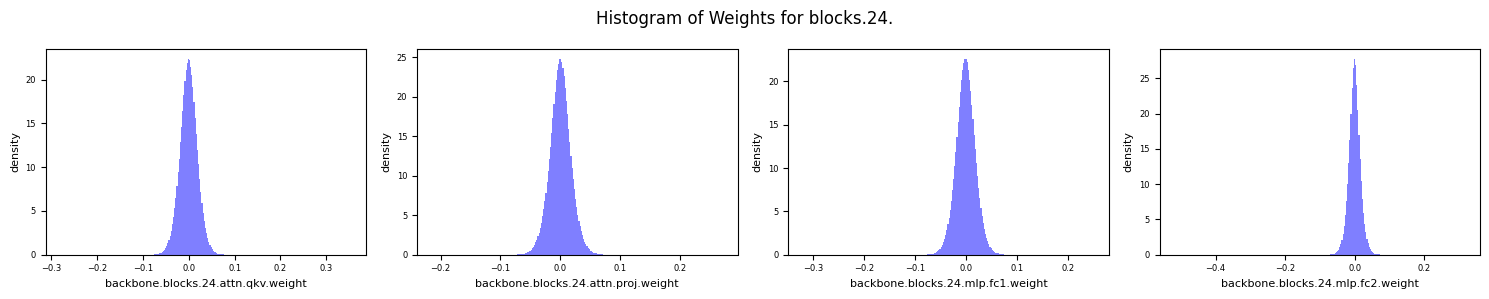

name: backbone.blocks.25.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.25.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.25.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.25.mlp.fc2.weight, param: torch.Size([1280, 5120])


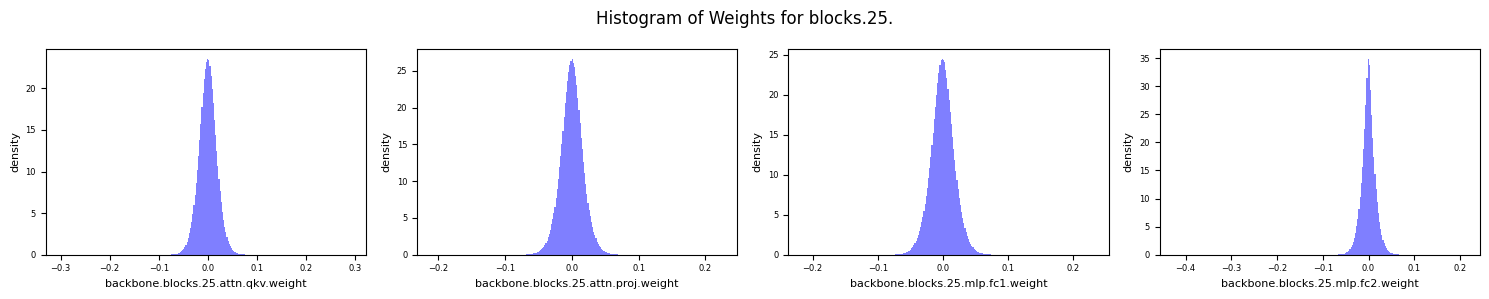

name: backbone.blocks.26.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.26.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.26.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.26.mlp.fc2.weight, param: torch.Size([1280, 5120])


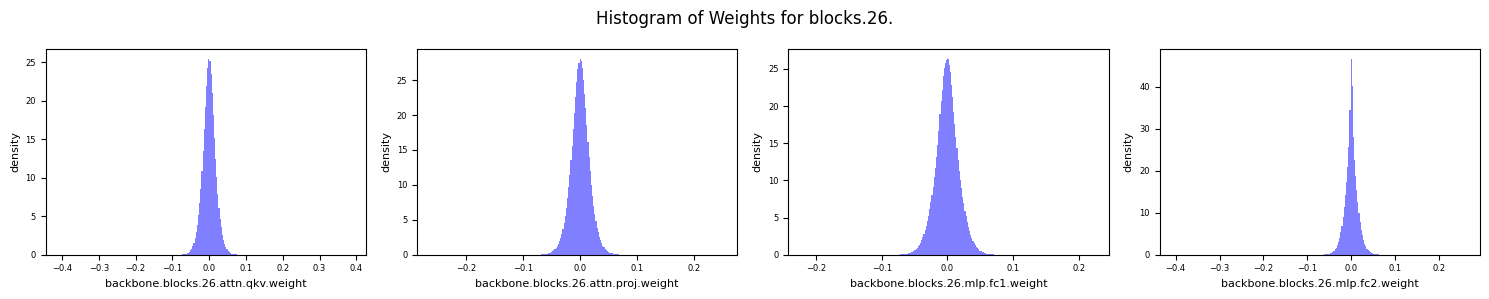

name: backbone.blocks.27.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.27.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.27.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.27.mlp.fc2.weight, param: torch.Size([1280, 5120])


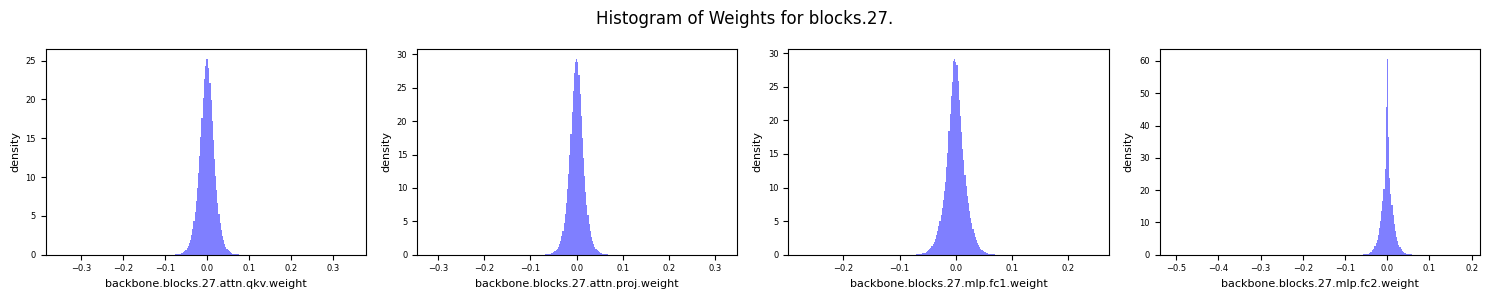

name: backbone.blocks.28.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.28.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.28.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.28.mlp.fc2.weight, param: torch.Size([1280, 5120])


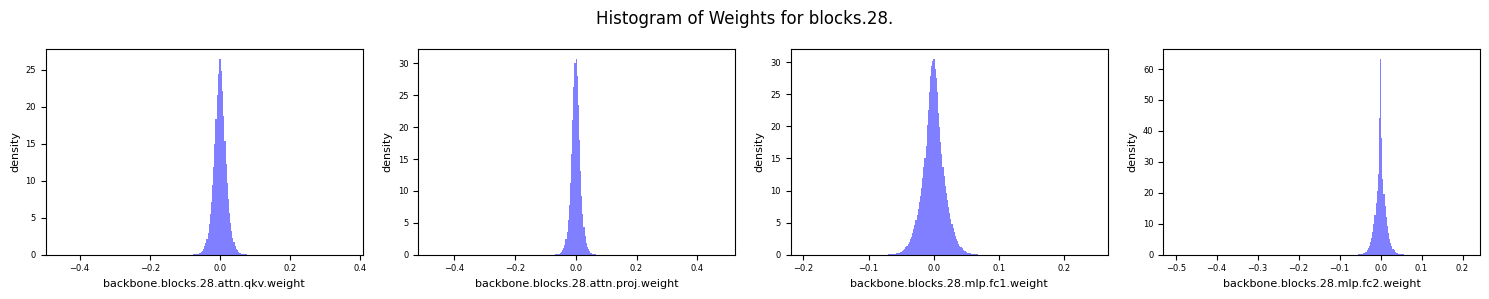

name: backbone.blocks.29.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.29.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.29.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.29.mlp.fc2.weight, param: torch.Size([1280, 5120])


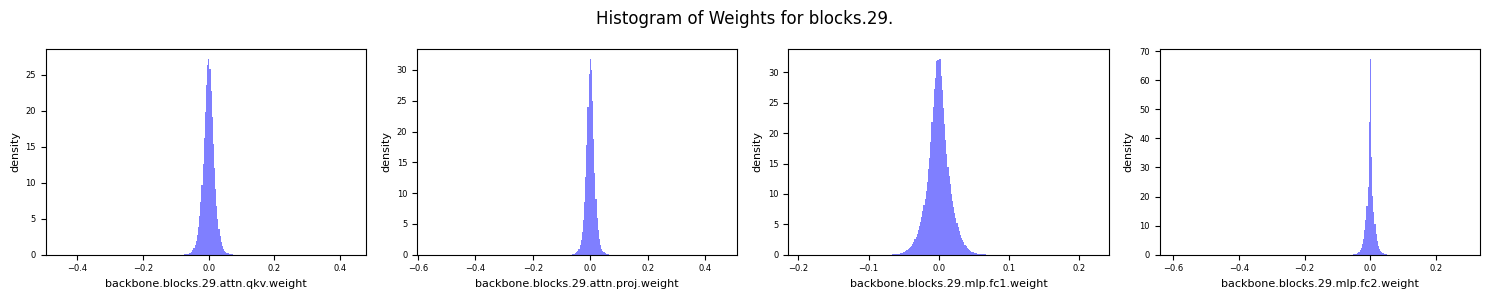

name: backbone.blocks.30.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.30.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.30.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.30.mlp.fc2.weight, param: torch.Size([1280, 5120])


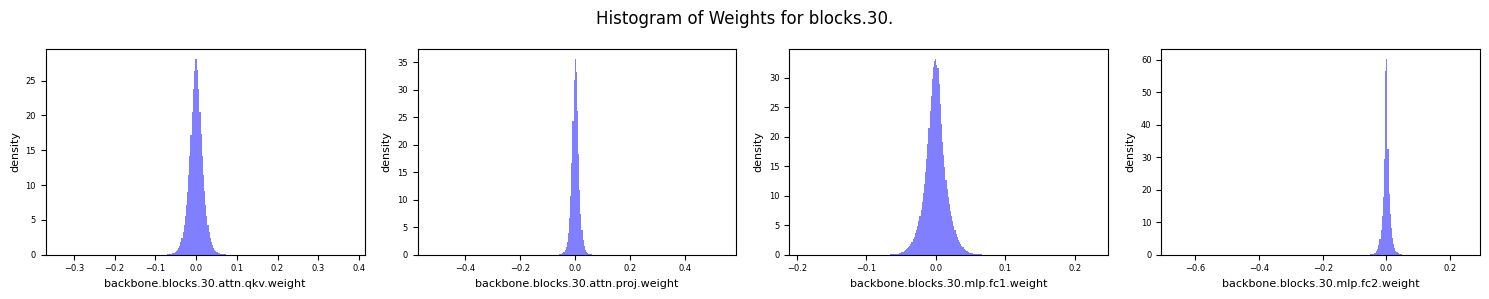

name: backbone.blocks.31.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.31.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.31.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.31.mlp.fc2.weight, param: torch.Size([1280, 5120])


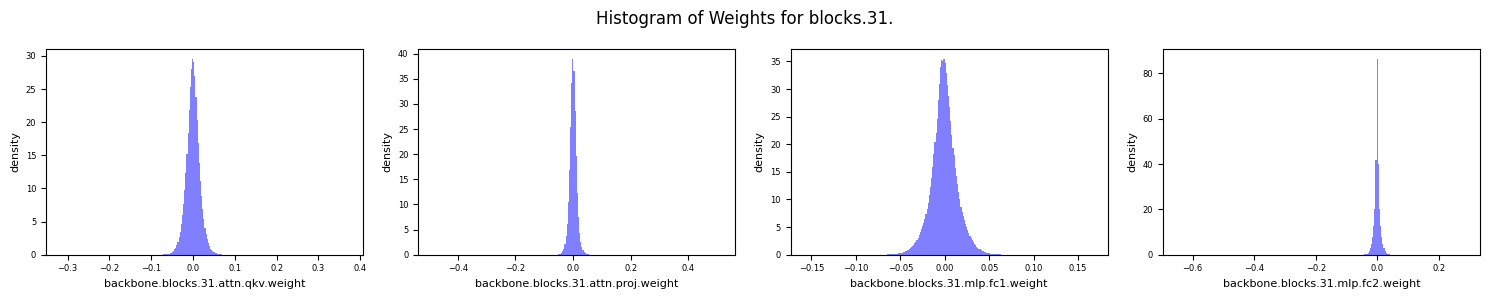

In [18]:
# 调用函数
for i in range(32):  # blocks.0 到 blocks.31
    block_name = f"blocks.{i}"  # 精确指定块名称
    plot_backbone_block_weights(model, block_name=f"{block_name}.")

## Pruning

In [20]:
# 定义稀疏比例
default_sparsity = 0.3  # 默认为50%的剪枝稀疏性

# 按层命名生成稀疏性字典
sparsity_dict = {}
num_blocks = 32  # 假设有32个 blocks，从 blocks.0 到 blocks.31

for i in range(num_blocks):
    block_prefix = f'backbone.blocks.{i}'
    sparsity = 0.5 if i < 16 else 0.2  # 前16个block用50%剪枝，后16个用20%剪枝
    sparsity_dict[f'{block_prefix}.attn.qkv.weight'] = sparsity
    sparsity_dict[f'{block_prefix}.attn.proj.weight'] = sparsity
    sparsity_dict[f'{block_prefix}.mlp.fc1.weight'] = sparsity
    sparsity_dict[f'{block_prefix}.mlp.fc2.weight'] = sparsity
# 打印稀疏性字典
print(sparsity_dict)

{'backbone.blocks.0.attn.qkv.weight': 0.5, 'backbone.blocks.0.attn.proj.weight': 0.5, 'backbone.blocks.0.mlp.fc1.weight': 0.5, 'backbone.blocks.0.mlp.fc2.weight': 0.5, 'backbone.blocks.1.attn.qkv.weight': 0.5, 'backbone.blocks.1.attn.proj.weight': 0.5, 'backbone.blocks.1.mlp.fc1.weight': 0.5, 'backbone.blocks.1.mlp.fc2.weight': 0.5, 'backbone.blocks.2.attn.qkv.weight': 0.5, 'backbone.blocks.2.attn.proj.weight': 0.5, 'backbone.blocks.2.mlp.fc1.weight': 0.5, 'backbone.blocks.2.mlp.fc2.weight': 0.5, 'backbone.blocks.3.attn.qkv.weight': 0.5, 'backbone.blocks.3.attn.proj.weight': 0.5, 'backbone.blocks.3.mlp.fc1.weight': 0.5, 'backbone.blocks.3.mlp.fc2.weight': 0.5, 'backbone.blocks.4.attn.qkv.weight': 0.5, 'backbone.blocks.4.attn.proj.weight': 0.5, 'backbone.blocks.4.mlp.fc1.weight': 0.5, 'backbone.blocks.4.mlp.fc2.weight': 0.5, 'backbone.blocks.5.attn.qkv.weight': 0.5, 'backbone.blocks.5.attn.proj.weight': 0.5, 'backbone.blocks.5.mlp.fc1.weight': 0.5, 'backbone.blocks.5.mlp.fc2.weight': 0.

In [24]:
import copy
def fine_grained_prune(tensor: torch.Tensor, sparsity: float) -> torch.Tensor:
    """
    对单个权重张量进行剪枝，返回掩码。
    :param tensor: torch.Tensor，需要剪枝的权重张量。
    :param sparsity: float，表示剪枝比例（0-1）。
    :return: torch.Tensor，掩码，0表示剪掉，1表示保留。
    """
    sparsity = min(max(0.0, sparsity), 1.0)  # 限制在 [0, 1] 范围内
    if sparsity == 1.0:
        return torch.zeros_like(tensor)  # 全部剪掉
    elif sparsity == 0.0:
        return torch.ones_like(tensor)  # 保留全部

    # 计算重要性（绝对值）并排序
    importance = tensor.abs()
    num_elements = tensor.numel()
    num_zeros = round(num_elements * sparsity)
    threshold = importance.view(-1).kthvalue(num_zeros).values.item()

    # 生成掩码
    mask = importance > threshold
    return mask
    
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        """
        初始化 FineGrainedPruner，生成掩码。
        :param model: nn.Module，待剪枝的模型。
        :param sparsity_dict: dict，表示各层的剪枝比例。
        """
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        """
        应用剪枝掩码，生成一个新的剪枝后的模型。
        :param model: nn.Module，待剪枝的模型。
        :return: nn.Module，剪枝后的新模型。
        """
        # 深拷贝模型，避免修改原模型
        # pruned_model = copy.deepcopy(model)
        for name, param in model.named_parameters():
            if name in self.masks:
                param.mul_(self.masks[name])  # 应用掩码
        return model

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        """
        生成剪枝掩码，表示哪些权重需要被保留。
        :param model: nn.Module，待剪枝的模型。
        :param sparsity_dict: dict，表示各层的剪枝比例。
        :return: dict，掩码（mask）。
        """
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1 and name in sparsity_dict:  # 仅处理稠密层
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

In [25]:
pruner = FineGrainedPruner(model, sparsity_dict)
pruned_model = pruner.apply(model)

name: backbone.blocks.0.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.0.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.0.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.0.mlp.fc2.weight, param: torch.Size([1280, 5120])


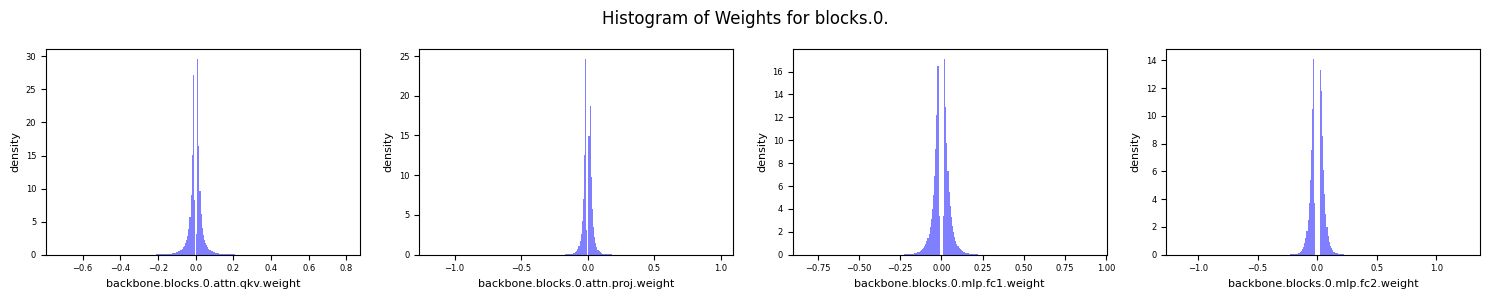

name: backbone.blocks.1.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.1.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.1.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.1.mlp.fc2.weight, param: torch.Size([1280, 5120])


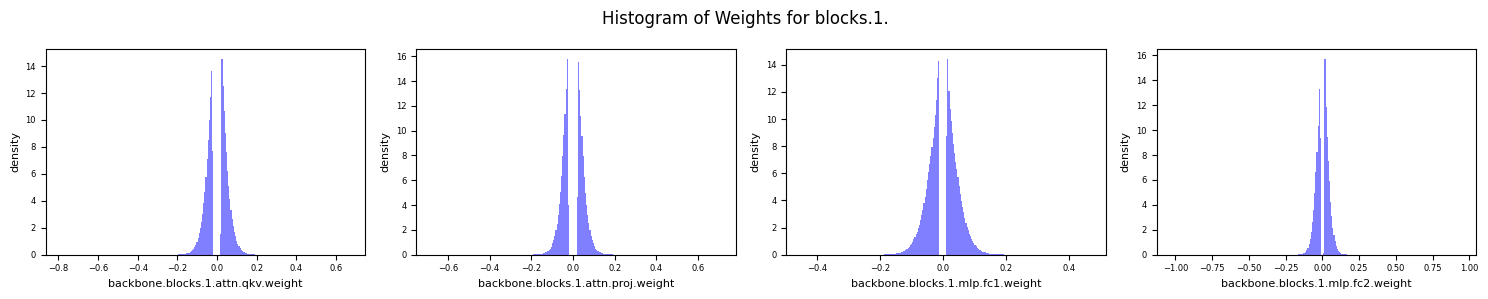

name: backbone.blocks.2.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.2.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.2.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.2.mlp.fc2.weight, param: torch.Size([1280, 5120])


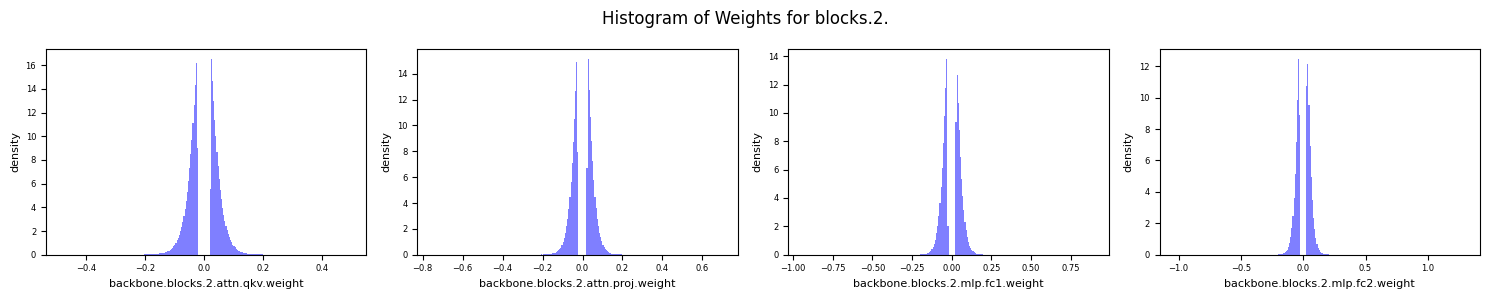

name: backbone.blocks.3.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.3.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.3.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.3.mlp.fc2.weight, param: torch.Size([1280, 5120])


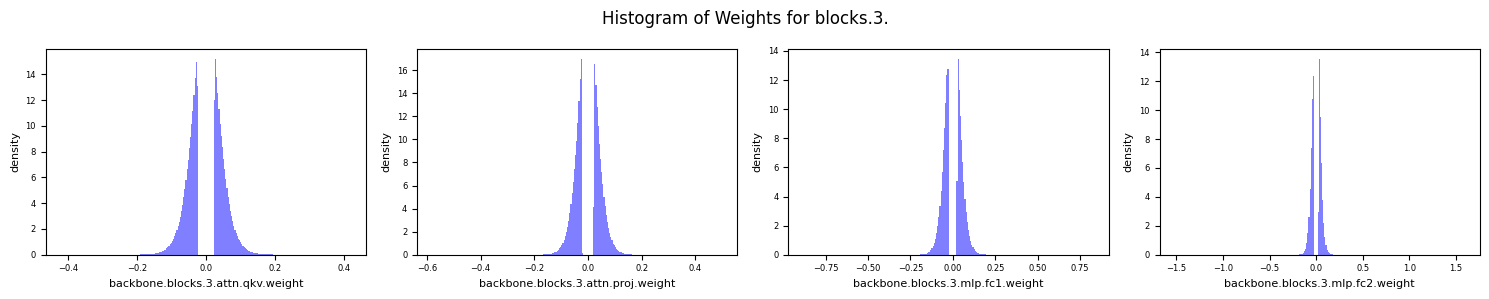

name: backbone.blocks.4.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.4.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.4.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.4.mlp.fc2.weight, param: torch.Size([1280, 5120])


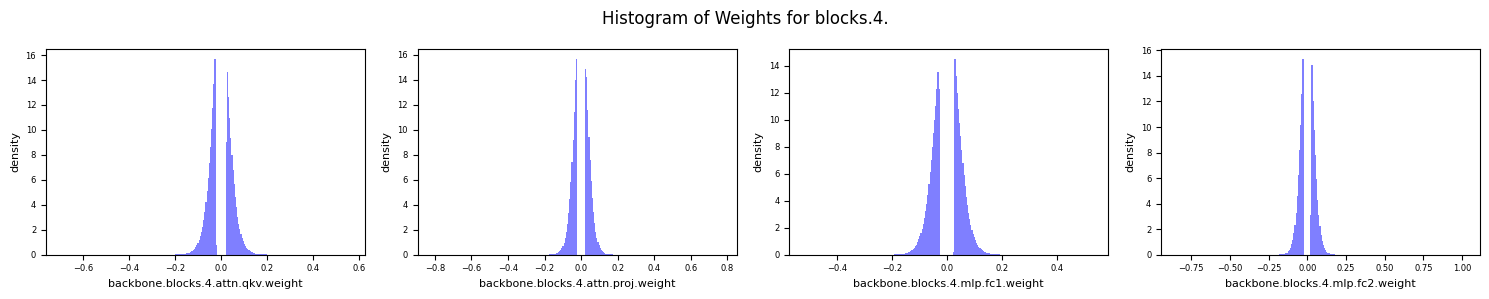

name: backbone.blocks.5.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.5.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.5.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.5.mlp.fc2.weight, param: torch.Size([1280, 5120])


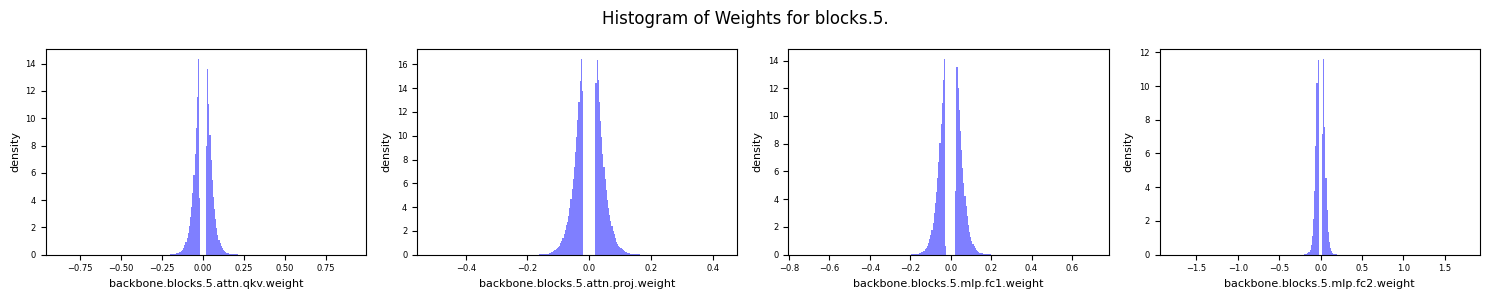

name: backbone.blocks.6.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.6.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.6.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.6.mlp.fc2.weight, param: torch.Size([1280, 5120])


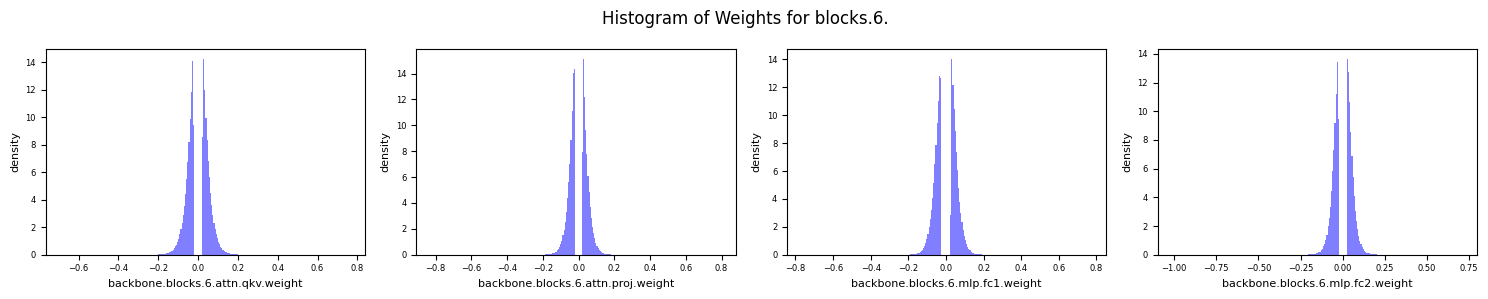

name: backbone.blocks.7.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.7.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.7.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.7.mlp.fc2.weight, param: torch.Size([1280, 5120])


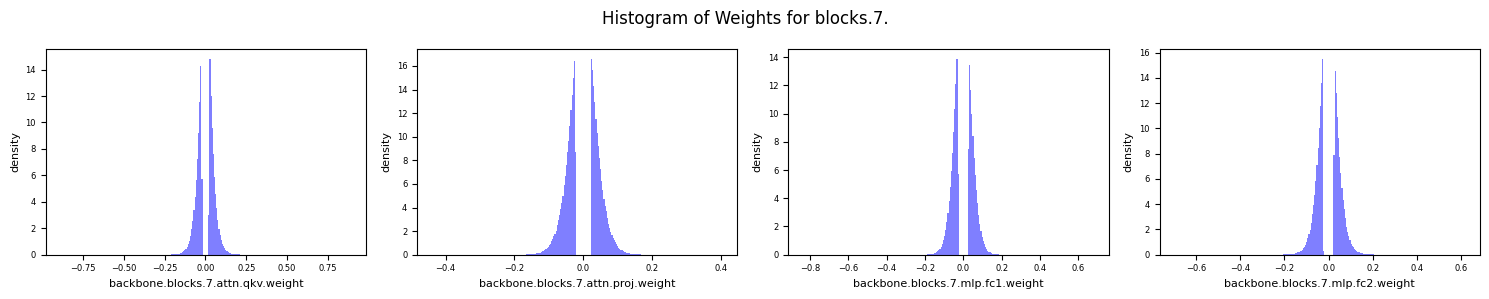

name: backbone.blocks.8.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.8.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.8.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.8.mlp.fc2.weight, param: torch.Size([1280, 5120])


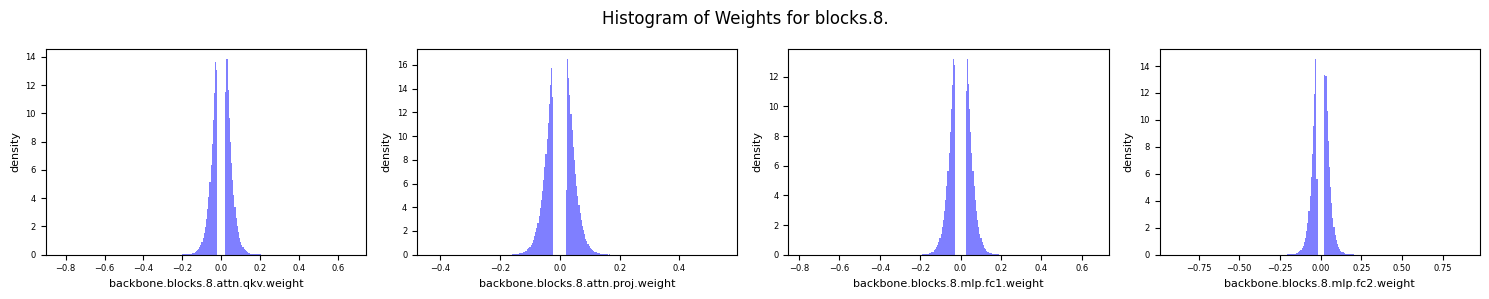

name: backbone.blocks.9.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.9.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.9.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.9.mlp.fc2.weight, param: torch.Size([1280, 5120])


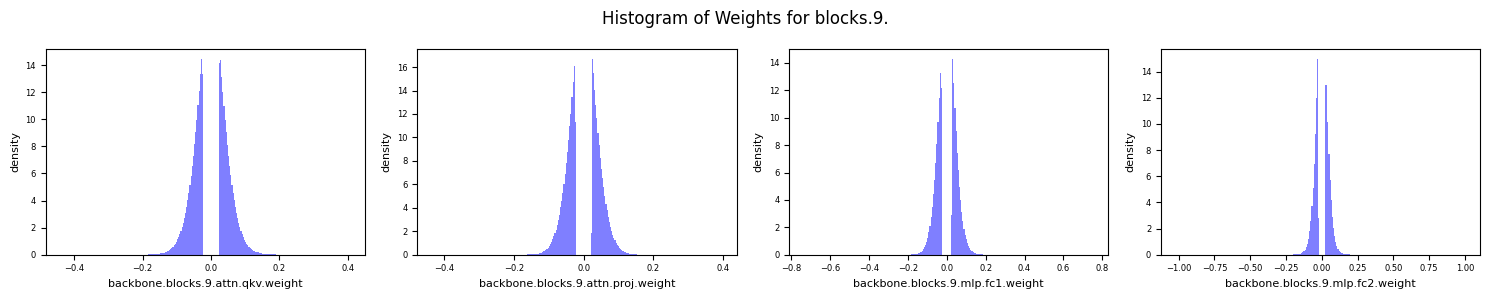

name: backbone.blocks.10.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.10.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.10.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.10.mlp.fc2.weight, param: torch.Size([1280, 5120])


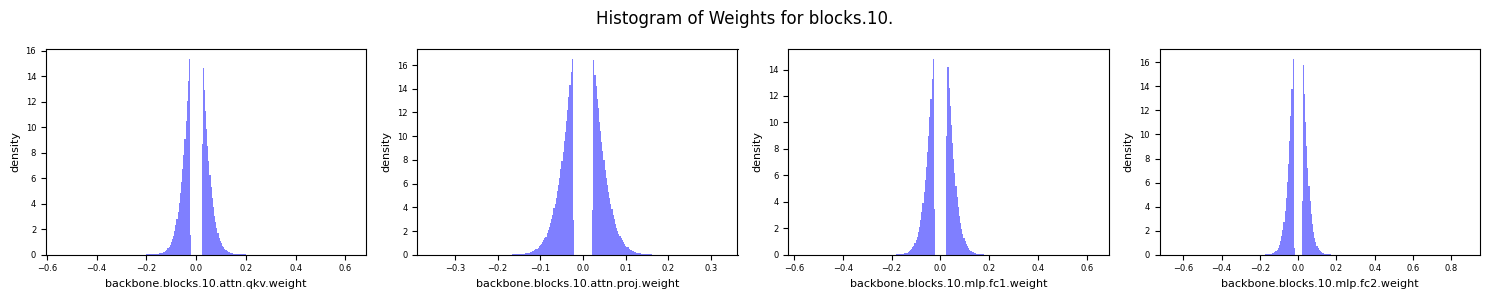

name: backbone.blocks.11.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.11.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.11.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.11.mlp.fc2.weight, param: torch.Size([1280, 5120])


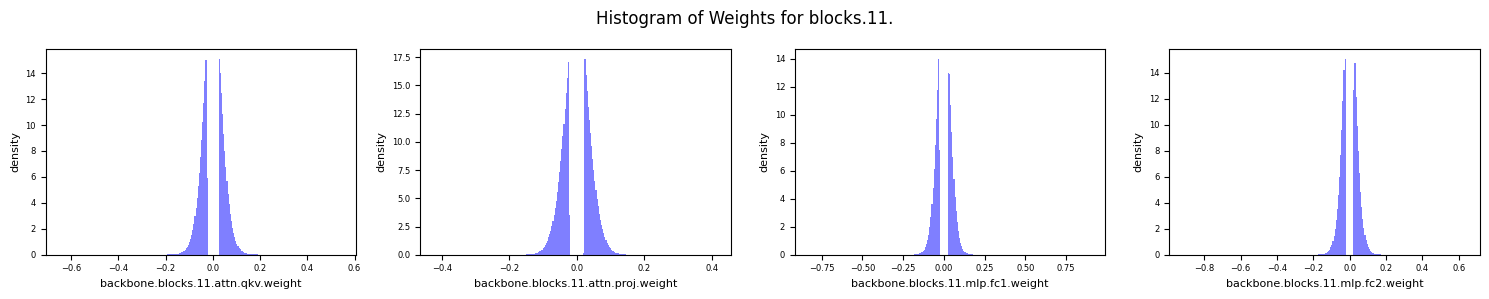

name: backbone.blocks.12.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.12.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.12.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.12.mlp.fc2.weight, param: torch.Size([1280, 5120])


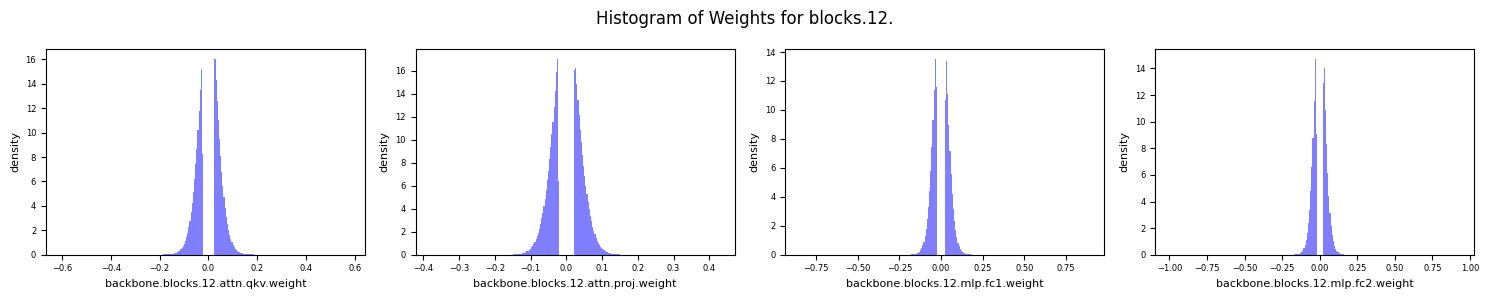

name: backbone.blocks.13.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.13.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.13.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.13.mlp.fc2.weight, param: torch.Size([1280, 5120])


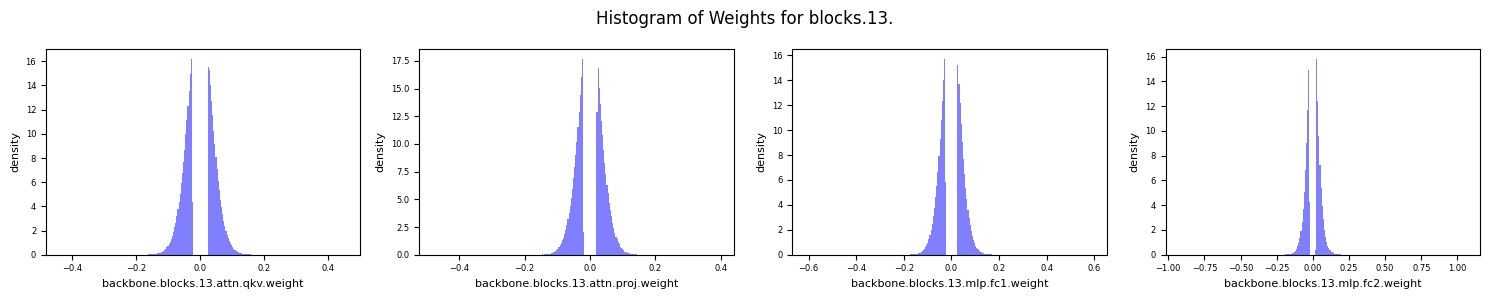

name: backbone.blocks.14.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.14.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.14.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.14.mlp.fc2.weight, param: torch.Size([1280, 5120])


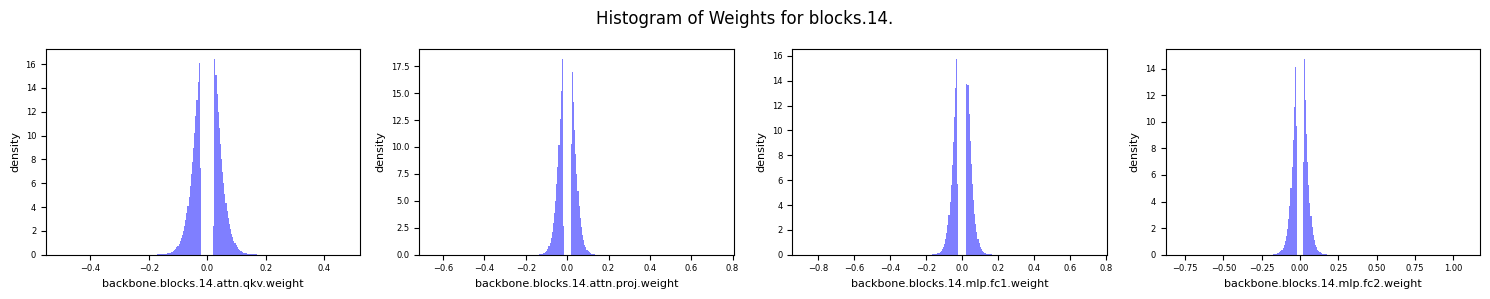

name: backbone.blocks.15.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.15.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.15.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.15.mlp.fc2.weight, param: torch.Size([1280, 5120])


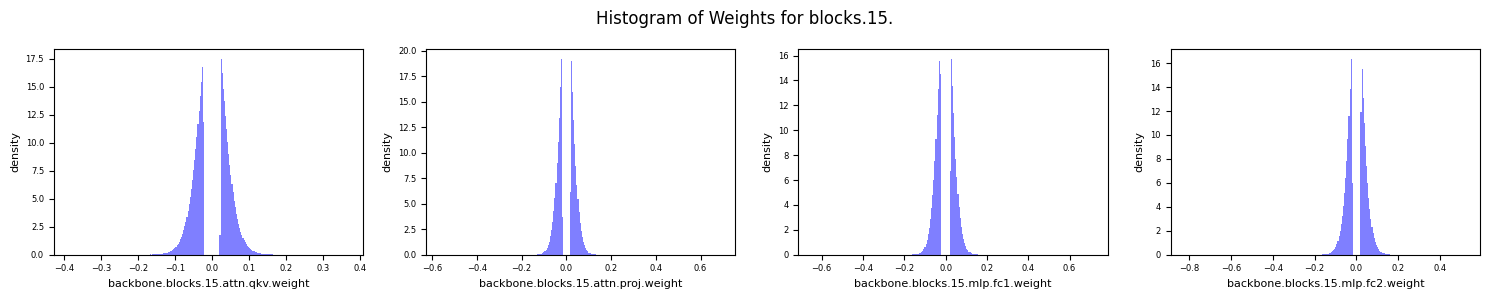

name: backbone.blocks.16.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.16.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.16.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.16.mlp.fc2.weight, param: torch.Size([1280, 5120])


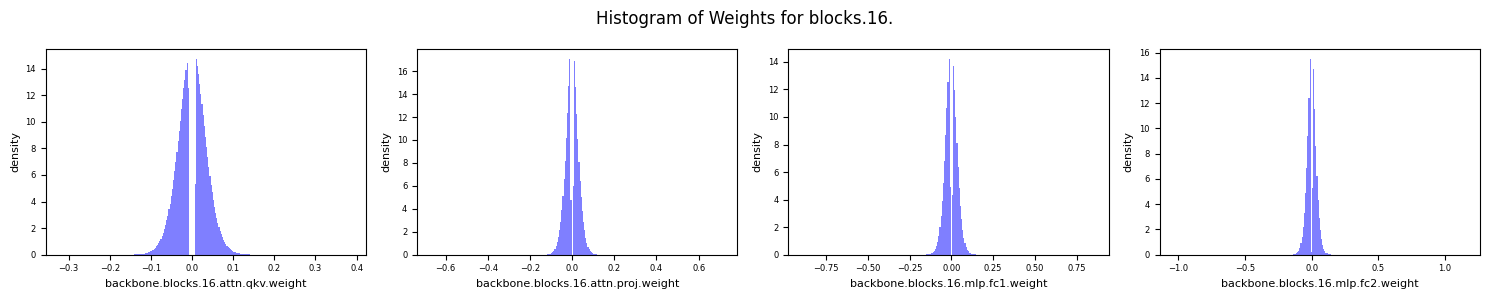

name: backbone.blocks.17.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.17.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.17.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.17.mlp.fc2.weight, param: torch.Size([1280, 5120])


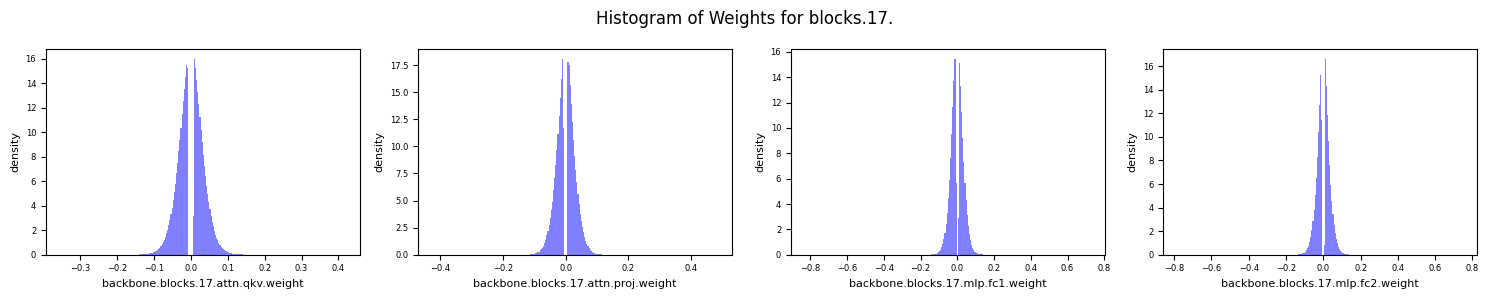

name: backbone.blocks.18.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.18.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.18.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.18.mlp.fc2.weight, param: torch.Size([1280, 5120])


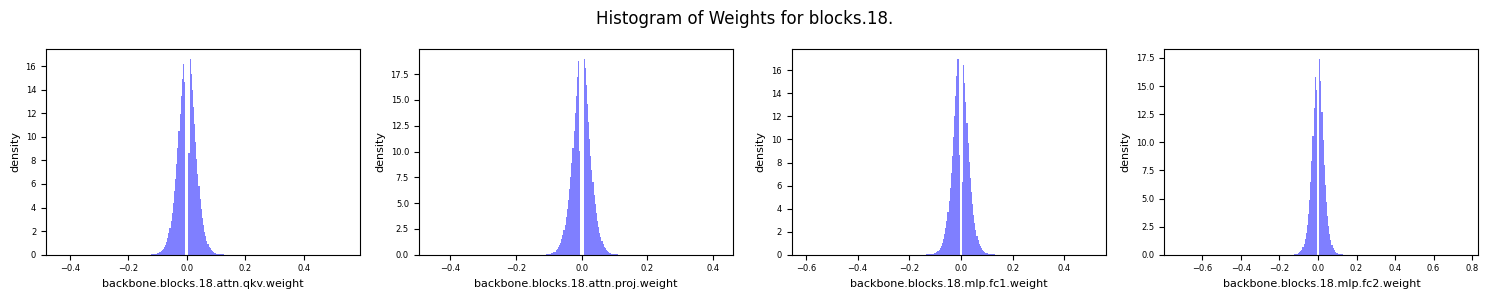

name: backbone.blocks.19.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.19.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.19.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.19.mlp.fc2.weight, param: torch.Size([1280, 5120])


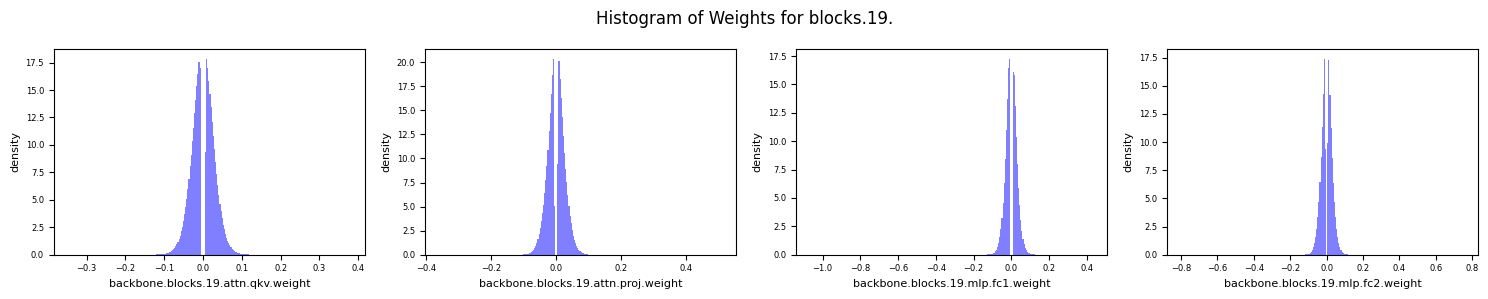

name: backbone.blocks.20.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.20.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.20.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.20.mlp.fc2.weight, param: torch.Size([1280, 5120])


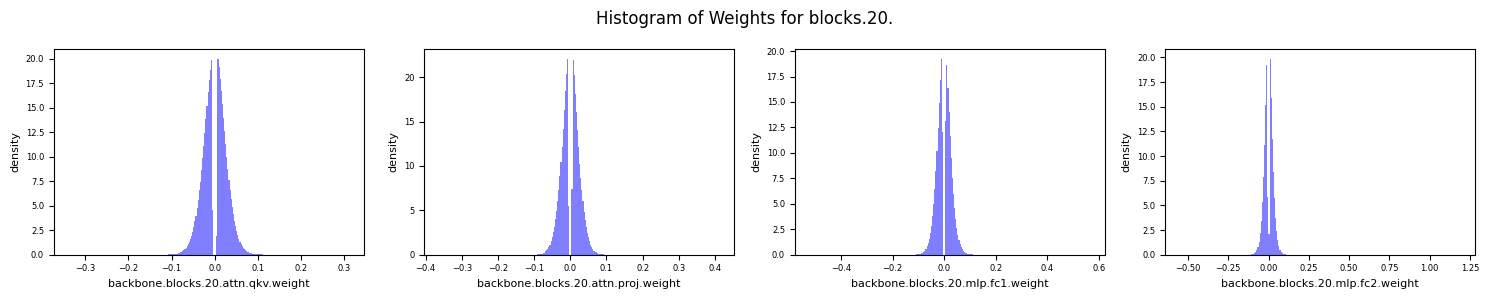

name: backbone.blocks.21.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.21.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.21.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.21.mlp.fc2.weight, param: torch.Size([1280, 5120])


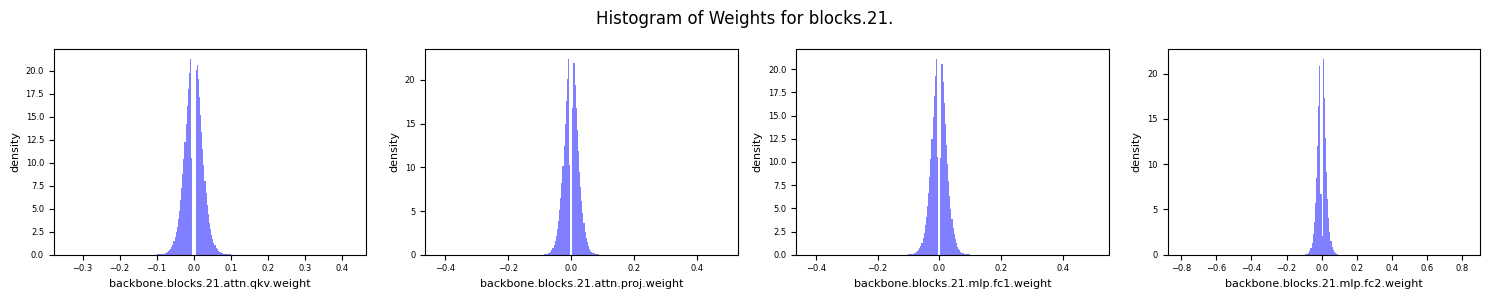

name: backbone.blocks.22.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.22.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.22.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.22.mlp.fc2.weight, param: torch.Size([1280, 5120])


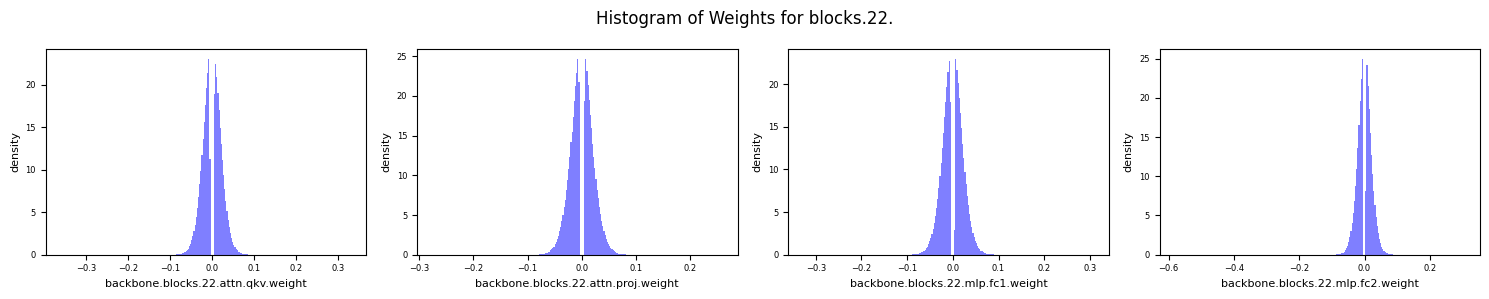

name: backbone.blocks.23.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.23.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.23.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.23.mlp.fc2.weight, param: torch.Size([1280, 5120])


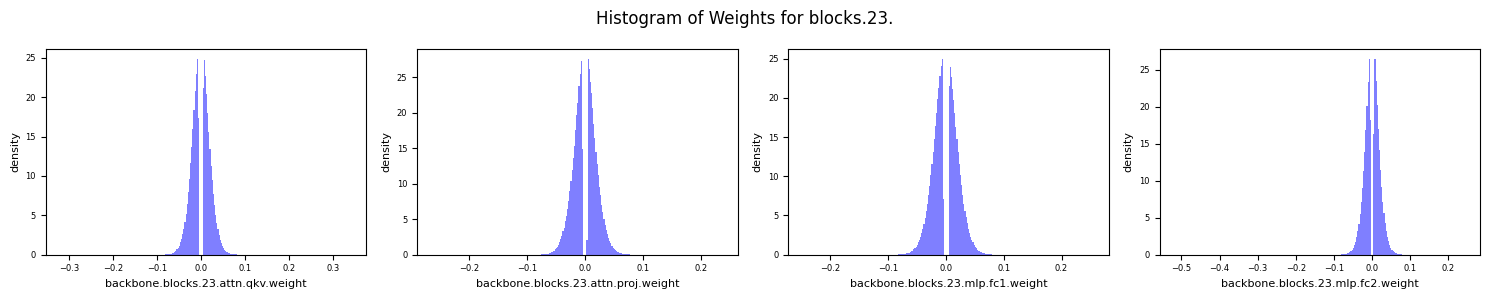

name: backbone.blocks.24.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.24.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.24.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.24.mlp.fc2.weight, param: torch.Size([1280, 5120])


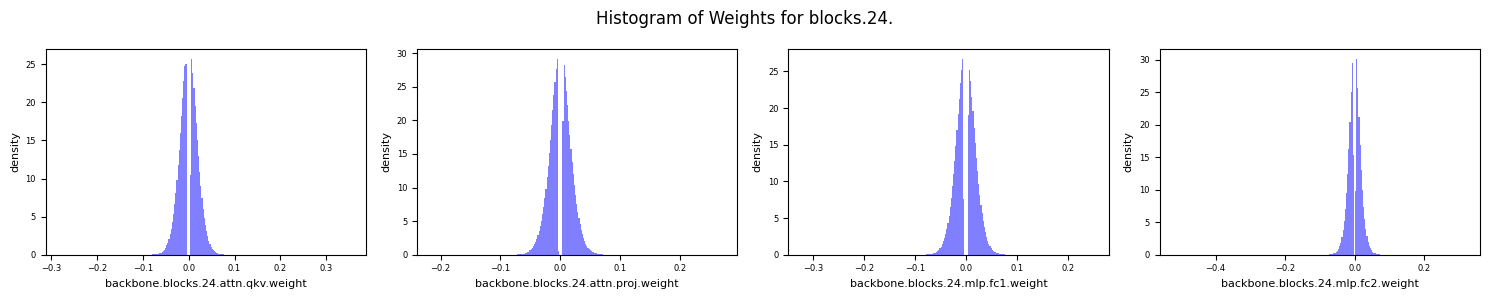

name: backbone.blocks.25.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.25.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.25.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.25.mlp.fc2.weight, param: torch.Size([1280, 5120])


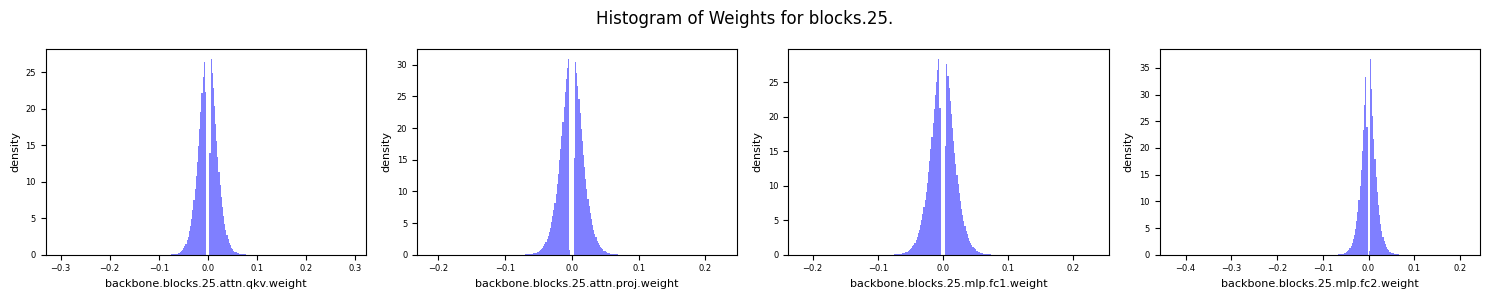

name: backbone.blocks.26.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.26.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.26.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.26.mlp.fc2.weight, param: torch.Size([1280, 5120])


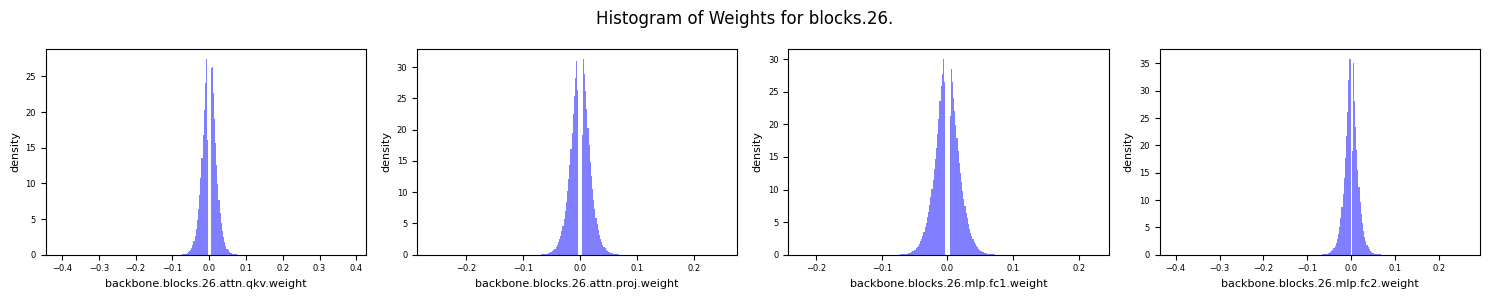

name: backbone.blocks.27.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.27.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.27.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.27.mlp.fc2.weight, param: torch.Size([1280, 5120])


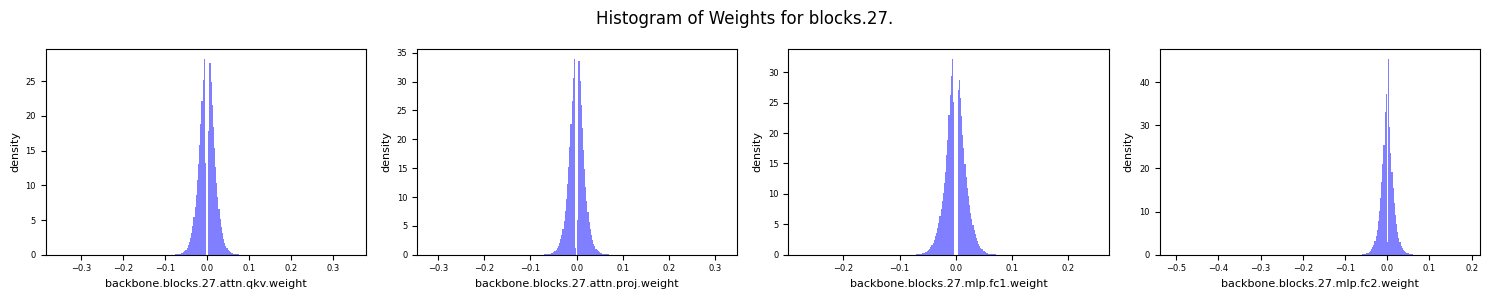

name: backbone.blocks.28.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.28.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.28.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.28.mlp.fc2.weight, param: torch.Size([1280, 5120])


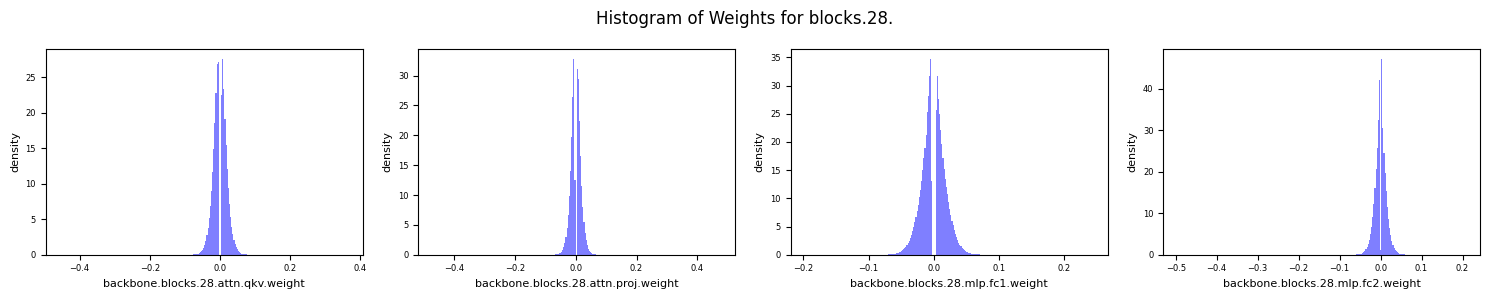

name: backbone.blocks.29.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.29.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.29.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.29.mlp.fc2.weight, param: torch.Size([1280, 5120])


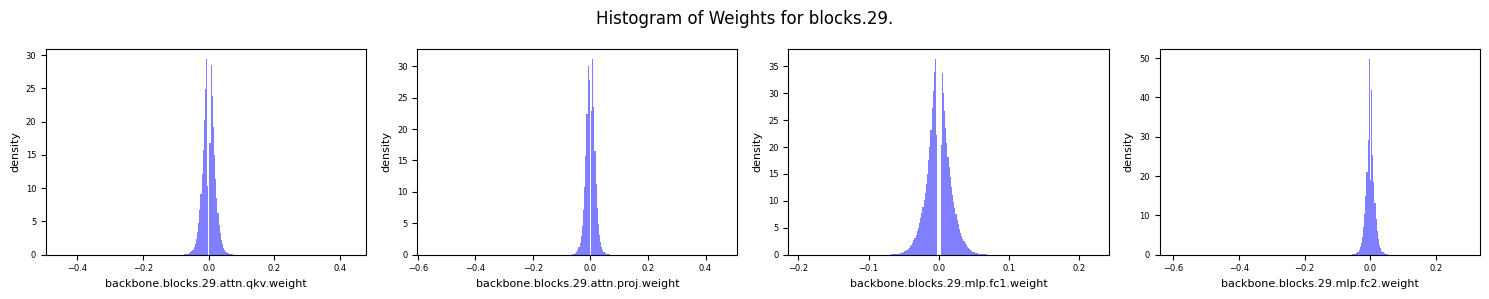

name: backbone.blocks.30.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.30.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.30.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.30.mlp.fc2.weight, param: torch.Size([1280, 5120])


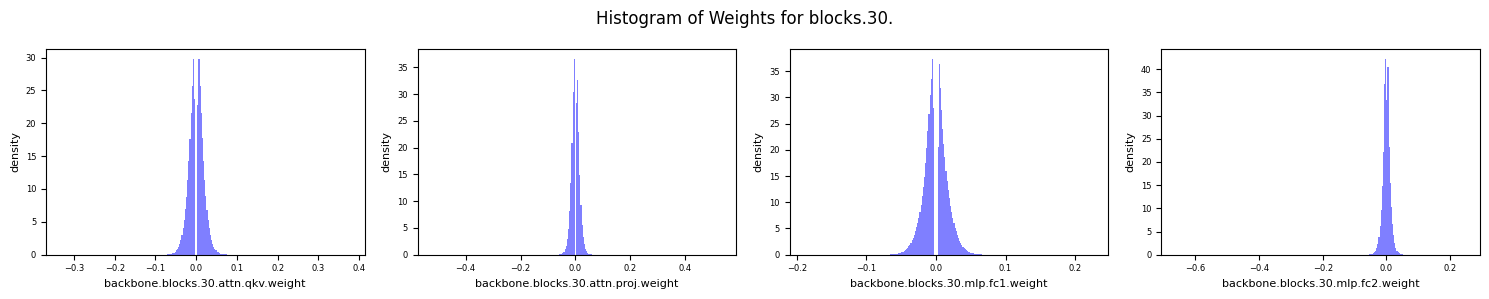

name: backbone.blocks.31.attn.qkv.weight, param: torch.Size([3840, 1280])
name: backbone.blocks.31.attn.proj.weight, param: torch.Size([1280, 1280])
name: backbone.blocks.31.mlp.fc1.weight, param: torch.Size([5120, 1280])
name: backbone.blocks.31.mlp.fc2.weight, param: torch.Size([1280, 5120])


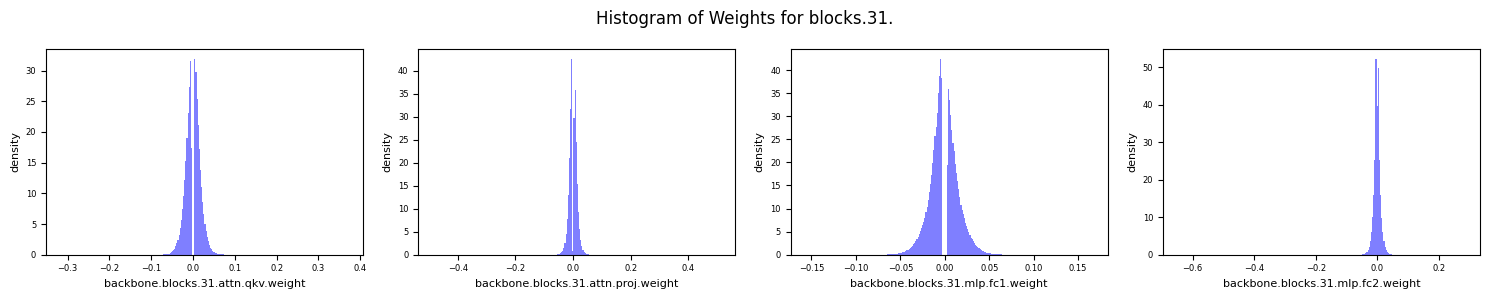

In [26]:
for i in range(32):  # blocks.0 到 blocks.31
    block_name = f"blocks.{i}"  # 精确指定块名称
    plot_backbone_block_weights(model, block_name=f"{block_name}.", count_nonzero_only=True)

100 / 1753 samples
100 samples
kp0_pck_0.05: 0.40963855421686746
kp1_pck_0.05: 0.38202247191011235
kp2_pck_0.05: 0.3723404255319149
kp3_pck_0.05: 0.375
kp4_pck_0.05: 0.37755102040816324
kp5_pck_0.05: 0.4148936170212766
kp6_pck_0.05: 0.48936170212765956
kp7_pck_0.05: 0.4583333333333333
kp8_pck_0.05: 0.4479166666666667
kp9_pck_0.05: 0.42105263157894735
kp10_pck_0.05: 0.5051546391752577
kp11_pck_0.05: 0.38144329896907214
kp12_pck_0.05: 0.425531914893617
kp13_pck_0.05: 0.46808510638297873
kp14_pck_0.05: 0.4421052631578947
kp15_pck_0.05: 0.4421052631578947
kp16_pck_0.05: 0.4479166666666667
kp17_pck_0.05: 0.42857142857142855
kp18_pck_0.05: 0.39361702127659576
kp19_pck_0.05: 0.3333333333333333
kp20_pck_0.05: 0.358695652173913
kpAvg_pck_0.05: 0.41784142907398064
kp0_pck_0.1: 0.7469879518072289
kp1_pck_0.1: 0.7865168539325843
kp2_pck_0.1: 0.8191489361702128
kp3_pck_0.1: 0.7708333333333334
kp4_pck_0.1: 0.7244897959183674
kp5_pck_0.1: 0.8085106382978723
kp6_pck_0.1: 0.8297872340425532
kp7_pck_0.1

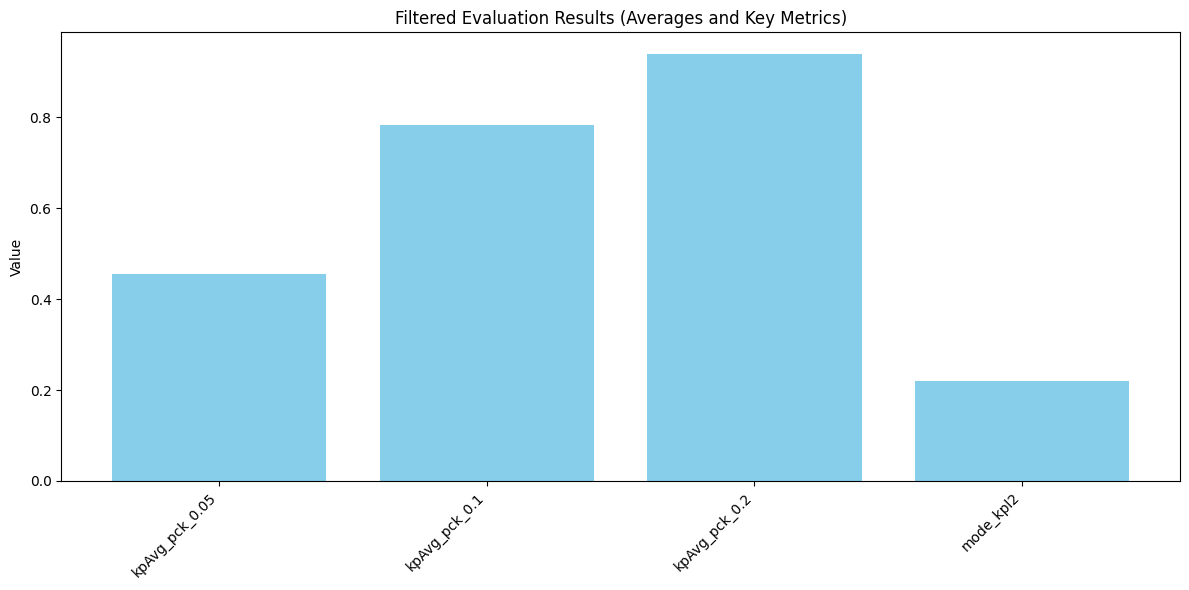

In [27]:
avg_loss_dict, metrics_summary = run_eval_and_collect_results(
    model=model,
    model_cfg=model_cfg,
    dataset_cfg=dataset_cfg,
    device=device,
    batch_size=100,
    num_workers=4,
    log_freq=10
)

# 保存并可视化结果
save_and_visualize_results(avg_loss_dict, metrics_summary, output_folder="results")

In [75]:
model_size = sum(p.numel() * p.element_size() for p in model.parameters())
print("Model Size (bytes):", model_size)
print("Model Size (MB)", model_size / 1024 /1024)

Model Size (bytes): 2687820192
Model Size (MB) 2563.3050842285156


In [33]:
import time

torch.cuda.synchronize()  # 이전 연산이 완료될 때까지 대기
start_time = time.time()
with torch.no_grad():
    model(batch)
torch.cuda.synchronize()  # 모델 추론이 완료될 때까지 대기
end_time = time.time()
latency = end_time - start_time
print("Latency (seconds):", latency)

Latency (seconds): 0.039716243743896484


### Quantization
Post-Training Quantization, PTQ

In [6]:
import torch
from torch import nn
from fast_pytorch_kmeans import KMeans

# def quantize_linear_layer(layer, method='linear', bitwidth=8):
#     if not isinstance(layer, nn.Linear):
#         return layer  # 如果不是 Linear 层，直接返回
#     if method == 'linear':
#         quantized_weight, weight_scale, _ = linear_quantize(layer.weight.data, bitwidth)
#         quantized_bias, bias_scale, _ = linear_quantize(layer.bias.data, bitwidth)
#         return QuantizedLinear(
#             quantized_weight, quantized_bias, 1.0, weight_scale, 1.0
#         )
#     elif method == 'kmeans':
#         codebook, quantized_weight = k_means_quantize(layer.weight.data, bitwidth)
#         quantized_bias, _, _ = linear_quantize(layer.bias.data, bitwidth)
#         return QuantizedLinear(
#             quantized_weight, quantized_bias, 1.0, 1.0, 1.0
#         )
#     else:
#         raise ValueError("Unsupported quantization method")

# def quantize_block(block, method='linear', bitwidth=8):
#     for name, module in block.named_children():
#         if isinstance(module, nn.Linear):
#             setattr(block, name, quantize_linear_layer(module, method, bitwidth))
#         elif isinstance(module, nn.Sequential) or isinstance(module, nn.ModuleList):
#             quantize_block(module, method, bitwidth)
#     return block

# def quantize_model(model, method='kmeans', bitwidth=8):
#     for name, module in model.named_modules():
#         if hasattr(module, 'attn') and hasattr(module, 'mlp'):  # 通过特征判断是否为 Block
#             quantize_block(module, method, bitwidth)
#     return model

from fast_pytorch_kmeans import KMeans
import torch
from torch import nn

# QuantizedLinear 类定义
class QuantizedLinear(nn.Module):
    def __init__(self, weight, bias, input_scale, weight_scale, output_scale):
        super(QuantizedLinear, self).__init__()
        self.weight = weight  # 整数类型
        self.bias = bias  # 整数类型（或 None）
        self.input_scale = input_scale
        self.weight_scale = weight_scale
        self.output_scale = output_scale

    def forward(self, x):
        # 将输入先缩放到量化范围，完成整数推理后再还原为浮点
        x = x / self.input_scale
        output = (x @ self.weight.T + (self.bias if self.bias is not None else 0))
        return output * (self.weight_scale * self.input_scale)

# Linear 量化函数

def linear_quantize(fp_tensor, bitwidth):
    """
    Perform linear quantization on a given tensor.
    Args:
        fp_tensor: Floating-point tensor to quantize.
        bitwidth: Number of bits for quantization.
    Returns:
        Quantized tensor, scale factor, and zero point.
    """
    assert bitwidth > 0, "Bitwidth must be positive."

    qmin, qmax = -(2 ** (bitwidth - 1)), (2 ** (bitwidth - 1)) - 1
    min_val, max_val = fp_tensor.min().item(), fp_tensor.max().item()
    scale = (max_val - min_val) / (qmax - qmin) if max_val != min_val else 1.0
    zero_point = round(qmin - min_val / scale) if max_val != min_val else 0

    quantized_tensor = torch.clamp(
        ((fp_tensor / scale).round() + zero_point), qmin, qmax
    ).to(torch.int8)

    return quantized_tensor, scale, zero_point

# KMeans 量化函数
def k_means_quantize(fp_tensor, bitwidth, chunk_size=1024):
    """
    Perform k-means quantization on a given tensor with chunking.
    Args:
        fp_tensor: Floating-point tensor to quantize.
        bitwidth: Number of bits for quantization.
        chunk_size: Number of rows to process at a time.
    Returns:
        Codebook, quantized tensor.
    """
    n_clusters = 2 ** bitwidth
    kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=0)

    fp_tensor_flat = fp_tensor.view(-1, 1).cpu()
    quantized_tensor = torch.zeros(fp_tensor_flat.size(0), dtype=torch.int8)

    # 分块处理
    for i in range(0, fp_tensor_flat.size(0), chunk_size):
        end = min(i + chunk_size, fp_tensor_flat.size(0))
        sub_tensor = fp_tensor_flat[i:end]
        sub_quantized = kmeans.fit_predict(sub_tensor)
        quantized_tensor[i:end] = sub_quantized.view(-1)

    codebook = kmeans.centroids
    return codebook, quantized_tensor.view(fp_tensor.size())

# 量化 Linear 层
def quantize_linear_layer(layer, method='linear', bitwidth=8, device="cuda:0"):
    if not isinstance(layer, nn.Linear):
        return layer

    if method == 'linear':
        quantized_weight, weight_scale, _ = linear_quantize(layer.weight.data.to(device), bitwidth)
        quantized_bias, bias_scale, _ = (
            linear_quantize(layer.bias.data.to(device), bitwidth) if layer.bias is not None else (None, None, None)
        )

        return QuantizedLinear(
            quantized_weight, quantized_bias, 1.0, weight_scale, 1.0
        ).to(device)
    elif method == 'kmeans':
        codebook, quantized_weight = k_means_quantize(layer.weight.data.to(device), bitwidth)
        quantized_bias, _, _ = (
            linear_quantize(layer.bias.data.to(device), bitwidth) if layer.bias is not None else (None, None, None)
        )

        return QuantizedLinear(
            quantized_weight, quantized_bias, 1.0, 1.0, 1.0
        ).to(device)
    else:
        raise ValueError("Unsupported quantization method")

# 量化 LayerNorm 层
def quantize_layernorm_layer(layer, method='linear', bitwidth=8, device="cuda:0"):
    if not isinstance(layer, nn.LayerNorm):
        return layer

    quantized_weight, weight_scale, _ = linear_quantize(layer.weight.data.to(device), bitwidth)
    quantized_bias, bias_scale, _ = (
        linear_quantize(layer.bias.data.to(device), bitwidth) if layer.bias is not None else (None, None, None)
    )

    # 替换为整数权重和偏置
    layer.weight = nn.Parameter(quantized_weight.to(device), requires_grad=False)
    if layer.bias is not None:
        layer.bias = nn.Parameter(quantized_bias.to(device), requires_grad=False)

    # 记录缩放因子，用于推理时还原
    layer.register_buffer("weight_scale", torch.tensor(weight_scale, dtype=torch.float32, device=device))
    if layer.bias is not None:
        layer.register_buffer("bias_scale", torch.tensor(bias_scale, dtype=torch.float32, device=device))

    return layer

# 量化 Block
def quantize_block(block, method='linear', bitwidth=8, device="cuda:0"):
    for name, module in block.named_children():
        if isinstance(module, nn.Linear):
            setattr(block, name, quantize_linear_layer(module, method, bitwidth, device))
        elif isinstance(module, nn.LayerNorm):
            setattr(block, name, quantize_layernorm_layer(module, method, bitwidth, device))
        else:
            quantize_block(module, method, bitwidth, device)  # 递归量化子模块
    torch.cuda.empty_cache()  # 清理显存
    return block

# 量化 ViT 模型
def quantize_model_vit(model, method='kmeans', bitwidth=8, device="cuda:0"):
    model.to(device)  # 将模型转移到目标设备
    for name, module in model.named_children():
        quantize_block(module, method, bitwidth, device)  # 替换子模块
    torch.cuda.empty_cache()  # 清理显存
    return model

In [7]:
quantized_model = quantize_model_vit(model, method='kmeans', bitwidth=8)

In [9]:
model_size = sum(p.numel() * p.element_size() for p in quantized_model.parameters())
print("Model Size (bytes):", model_size)
print("Model Size (MB)", model_size / 1024 /1024)

Model Size (bytes): 5138304
Model Size (MB) 4.9002685546875


In [155]:
# 量化计算工具
def compute_model_size(model):
    total_bytes = 0
    for name, param in model.named_buffers():  # 用 named_buffers 获取所有注册的量化权重和偏置
        element_size = param.element_size()  # 每个元素的字节大小
        total_bytes += param.numel() * element_size
    return total_bytes

# 示例模型量化后的大小计算
quantized_model = quantize_model(model, method='kmeans', bitwidth=8)
model_size = compute_model_size(quantized_model)
print(f"Quantized Model Size (bytes): {model_size}")
print(f"Quantized Model Size (MB): {model_size / 1024 / 1024}")

in Block(
  (norm1): LayerNorm(
    (1280,), eps=1e-06, elementwise_affine=True
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (attn): Attention(
    (qkv): Linear(
      in_features=1280, out_features=3840, bias=True
      (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
    )
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(
      in_features=1280, out_features=1280, bias=True
      (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
    )
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (drop_path): Identity()
  (norm2): LayerNorm(
    (1280,), eps=1e-06, elementwise_affine=True
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (mlp): Mlp(
    (fc1): Linear(
      in_features=1280, out_features=5120, bias=True
      (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
    )
    (act): GELU(approximate='none')
    (fc2): Linear(
      i

In [13]:
def calculate_model_size(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    total_size = param_size + buffer_size
    return total_size / (1024 ** 2)  # 转换为 MB

model_size = calculate_model_size(quantized_model)
print(f"Model size (static): {model_size:.2f} MB")

Model size (static): 6.33 MB
